Instead of rehashing how ARCH and GARCH models work, I thought I'd present a practical application of a GARCH model. 

Credits: While researching this project, I came across an amazing Medium article by Quantstart. The concept and the vast majority of the code below were borrowed from this article. 

Today, we'll be developing a trading strategy using ARIMA and GARCH. We'll use the models to forecast the next day's return for the SPY ETF in this case (but we could apply this to any instrument). 

Basic overview:

- Fit an ARIMA model to log returns 
- Fit GARCH model to residuals of ARIMA model using best ARIMA model parameters 
- Use GARCH model to forecast the next day's residual. Assuming the forecasted return for the next day is mean zero (given that it's a random walk?), the sign of the residual is a buy/sell signal. Otherwise, forecast would combine ARIMA mean forecast and GARCH volatility forecast 

In [53]:
import os
import sys

import pandas as pd
import numpy as np

import quandl
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

First, we import the historical price data for our instrument, the SPY ETF in this case. There are a lot of sources for this data, but I've use a Yahoo module and Google source data here. 

In [72]:
from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override() 

symbol = 'SPY'
data_source='google'
start_date = '2000-01-01'
end_date = '2018-05-01'
df = data.get_data_yahoo(symbol, start_date, end_date)
df.tail()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-25,262.910004,264.130005,260.850006,263.630005,263.630005,103840900
2018-04-26,264.790009,267.250000,264.290009,266.309998,266.309998,67731900
2018-04-27,267.000000,267.339996,265.500000,266.559998,266.559998,57053600
2018-04-30,267.260010,267.890015,264.429993,264.510010,264.510010,82182300
2018-05-01,263.869995,265.100006,262.109985,264.980011,264.980011,74203400


In [73]:
# log returns 
lrets = np.log(df/df.shift(1)).dropna()

In [74]:
# define function to handle plotting 
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

We then fit an ARIMA model to the closing price time series by iterating through various p, d and q ranges.  

In [75]:
# define function to get best arima model 
def get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.Close
res_tup = get_best_model(TS)

aic: -27591.18672 | order: (3, 0, 3)


In [76]:
order = res_tup[1]
model = res_tup[2]

Plotting the residuals of the best fit ARIMA model, we see that the resididuals appeaer to be white noise, which would imply that our model has 'captured' all of the signals within the time series. 

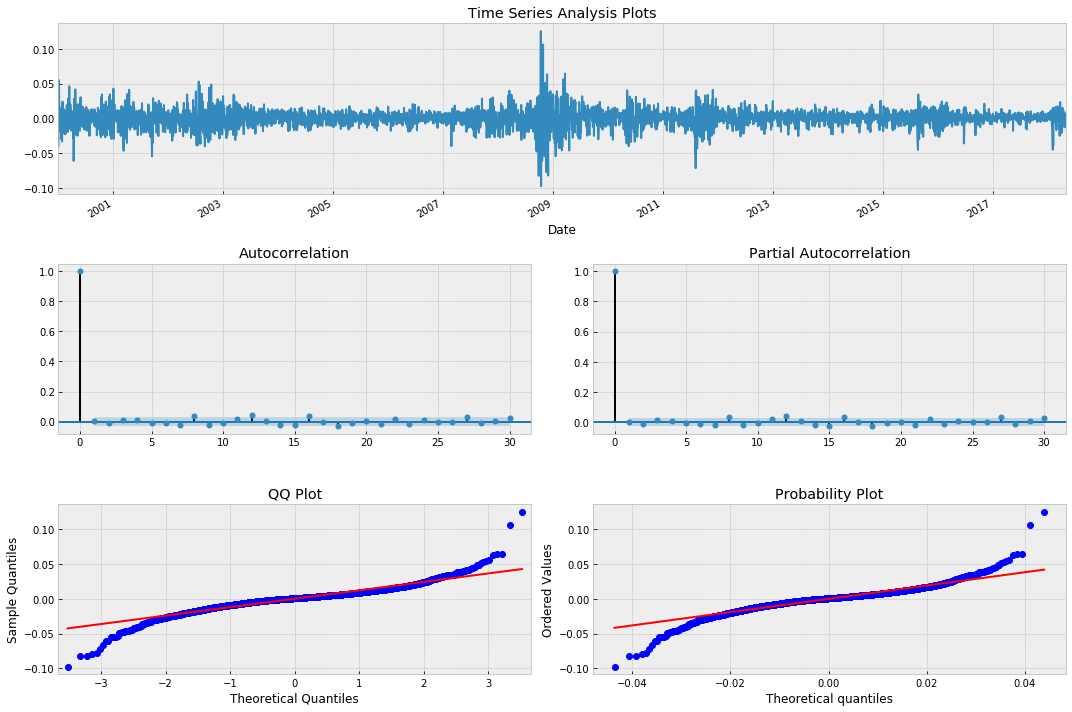

In [77]:
tsplot(model.resid, lags=30)

However, plotting the squared residuals, we see that there are still patterns within the data. From the significant spikes in both the ACF and PACF plots, we see that we can fit an ARMA model to this data, which is the essence of GARCH. 

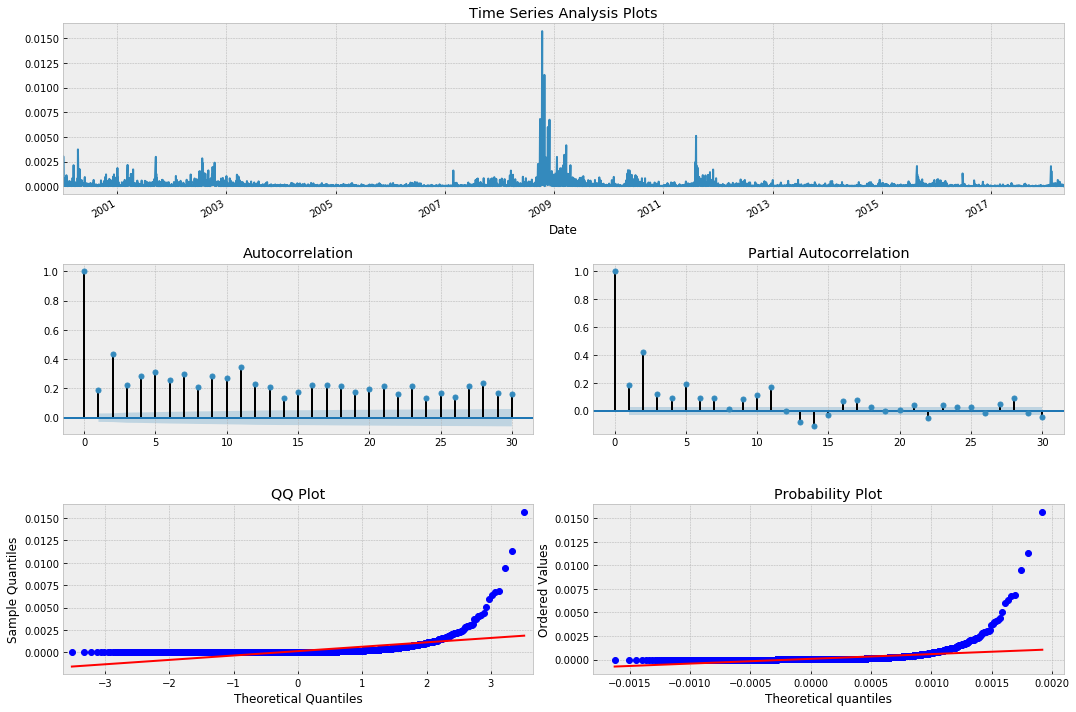

In [78]:
tsplot(model.resid**2, lags=30)

So we go ahead and fit a GARCH model to the residuals of the ARIMA model using the same p, o and q parameters of the best fit ARIMA model. 

In [85]:
# now we can fit the arch model using the best fir arima model parameters 

p_ = order[0]
o_ = order[1]
q_ = order[2]

# using a student T distribution usually provides a better fit 
# while ensuring p >= 2
am  = arch_model(model.resid, p=max(p_, 2), o=o_, q=q_, dist='StudentsT') 
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                     -55.668
Mean Model:                   Constant Mean   Adj. R-squared:                -55.668
Vol Model:                            GARCH   Log-Likelihood:                2357.60
Distribution:      Standardized Student's t   AIC:                          -4697.21
Method:                  Maximum Likelihood   BIC:                          -4639.29
                                              No. Observations:                 4610
Date:                      Sun, May 20 2018   Df Residuals:                     4601
Time:                              16:09:26   Df Model:                            9
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Now plotting the residiuals of the GARCH model, we still see only white noise in the residuals. 

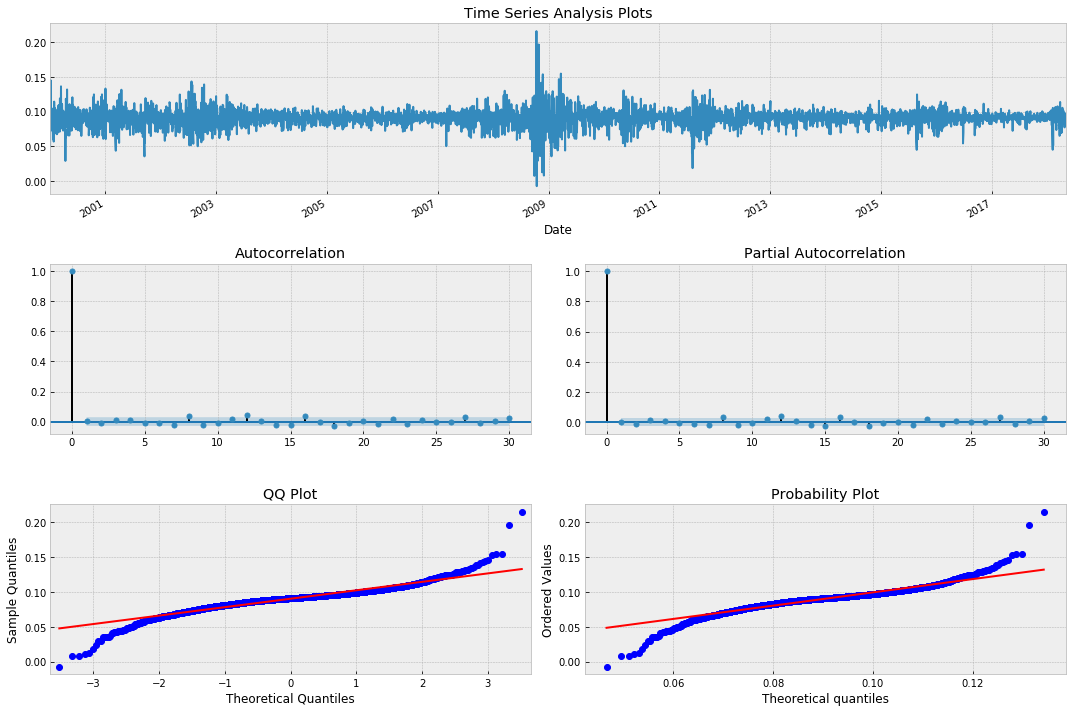

In [86]:
tsplot(res.resid, lags=30)

However, now the squared residuals also appear to be white noise as well, meaning that we've 'explained' the variance with our GARCH model. 

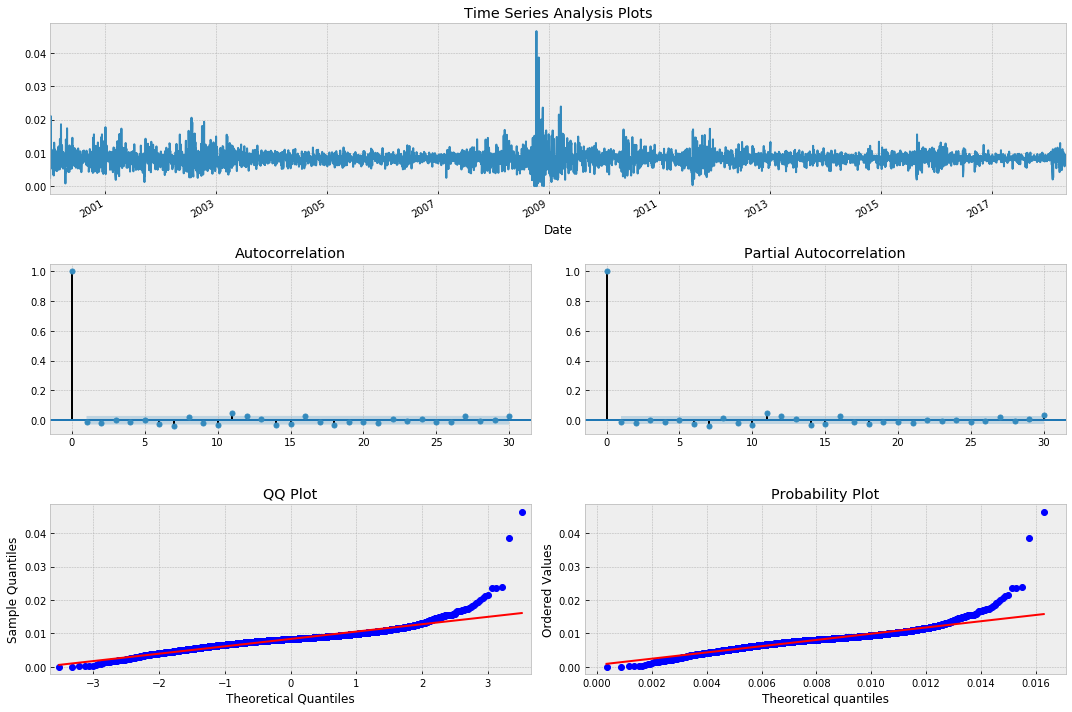

In [87]:
tsplot(res.resid**2, lags=30)

In [83]:
out = res.forecast(horizon=1, start=None, align='origin')
print(out.mean.iloc[-1])
print(out.variance.iloc[-1])

h.1   -0.090257
Name: 2018-05-01 00:00:00, dtype: float64
h.1    0.010412
Name: 2018-05-01 00:00:00, dtype: float64


Now we'll back test a simple trading strategy using this approach. We'll use a one-year window to train an ARIMA model, and then we'll fit a GARCH model to the residuals in order to forecast the next day's return. If the forecasted return is positive, we buy, and if it is negative, we short. 

In [84]:
# simple strategy implementation 
# buy when predicted return is positive 
# sell when predicted error is posit

windowLength = 252 
foreLength = len(lrets) - windowLength 
signal = 0*lrets[-foreLength:]

In [88]:
for d in range(foreLength):
    
    # create a rolling window by selecting 
    # values between d+1 and d+T of SPY returns 
    
    TS = lrets[(1+d):(windowLength+d)]['Close'] 
    
    # find the best fit arima model 
    # set d=0 since we've already taken log return of the series 
    res_tup = get_best_model(TS)
    order = res_tup[1]
    model = res_tup[2]
    
    # now with arima model fit, we feed parameters into garch model 
    p_ = order[0]
    o_ = order[1]
    q_ = order[2]
    
    am  = arch_model(model.resid, p=max(p_, 2), o=o_, q=q_, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    
    # generate a forecast of next day return using our fitted model 
    out = res.forecast(horizon=1, start=None, align='origin')
    
    # set trading signal equal to the sign of forecasted return 
    # buy if we expect positive returns, sell if negative 
    
    signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])

aic: -1400.04861 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1394.61716 | order: (2, 0, 2)
aic: -1394.93917 | order: (2, 0, 2)
aic: -1405.64890 | order: (4, 0, 2)
aic: -1405.17300 | order: (4, 0, 2)
aic: -1405.18794 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1404.25779 | order: (3, 0, 2)
aic: -1406.37310 | order: (2, 0, 2)
aic: -1407.31035 | order: (2, 0, 2)
aic: -1406.93639 | order: (4, 0, 2)
aic: -1406.77683 | order: (4, 0, 2)
aic: -1408.00531 | order: (4, 0, 2)
aic: -1408.00514 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1412.12430 | order: (4, 0, 4)
aic: -1411.94709 | order: (3, 0, 3)
aic: -1414.33563 | order: (4, 0, 4)
aic: -1414.37394 | order: (4, 0, 4)
aic: -1418.82770 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.90416 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.99721 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.75685 | order: (3, 0, 3)
aic: -1423.72768 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.46920 | order: (4, 0, 2)
aic: -1419.51368 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.01606 | order: (3, 0, 3)
aic: -1424.67071 | order: (4, 0, 2)
aic: -1424.33231 | order: (4, 0, 2)
aic: -1425.25520 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.19631 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.14140 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.35877 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.48106 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.53027 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.17616 | order: (4, 0, 2)
aic: -1424.33175 | order: (4, 0, 2)
aic: -1424.46025 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.27355 | order: (4, 0, 2)
aic: -1425.87872 | order: (4, 0, 2)
aic: -1426.09250 | order: (4, 0, 2)
aic: -1424.90829 | order: (4, 0, 2)
aic: -1425.08975 | order: (4, 0, 2)
aic: -1424.78209 | order: (4, 0, 2)
aic: -1424.62653 | order: (4, 0, 2)
aic: -1424.04434 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.10154 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.29176 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.21443 | order: (3, 0, 3)
aic: -1410.34791 | order: (3, 0, 3)
aic: -1411.03586 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1410.95474 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.49627 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.65443 | order: (4, 0, 4)
aic: -1412.53878 | order: (0, 0, 2)
aic: -1412.95143 | order: (3, 0, 3)
aic: -1411.49915 | order: (3, 0, 3)
aic: -1411.57797 | order: (4, 0, 2)
aic: -1406.57324 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1407.92505 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1403.84604 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1401.00163 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1401.98813 | order: (0, 0, 2)
aic: -1402.25658 | order: (0, 0, 2)
aic: -1400.43739 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1395.24052 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1395.35716 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1390.94618 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1390.24900 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1389.70967 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1388.65827 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1395.23947 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1393.75110 | order: (2, 0, 0)
aic: -1405.97689 | order: (2, 0, 0)
aic: -1411.46045 | order: (4, 0, 2)
aic: -1406.69028 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1405.85060 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1406.38164 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1406.17924 | order: (2, 0, 3)
aic: -1413.12994 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1413.41757 | order: (2, 0, 0)
aic: -1413.35551 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1412.07481 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1412.19626 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.33518 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.71398 | order: (4, 0, 4)
aic: -1417.84189 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.20921 | order: (2, 0, 4)
aic: -1416.53573 | order: (3, 0, 3)
aic: -1417.01534 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.31531 | order: (4, 0, 2)
aic: -1423.15828 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1424.07883 | order: (2, 0, 4)
aic: -1427.47628 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.34596 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.17194 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.56131 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.47201 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.48270 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.97836 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.49129 | order: (2, 0, 4)
aic: -1428.71634 | order: (4, 0, 4)
aic: -1424.51866 | order: (2, 0, 4)
aic: -1431.75789 | order: (4, 0, 4)
aic: -1430.90041 | order: (4, 0, 4)
aic: -1431.65366 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1436.40188 | order: (4, 0, 4)
aic: -1435.77584 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1432.29008 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1433.60030 | order: (4, 0, 4)
aic: -1434.72853 | order: (4, 0, 4)
aic: -1430.79161 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1430.52190 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1432.45525 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1435.61777 | order: (4, 0, 4)
aic: -1429.43519 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1433.61072 | order: (4, 0, 4)
aic: -1434.02590 | order: (4, 0, 4)
aic: -1432.52340 | order: (4, 0, 4)
aic: -1433.20446 | order: (4, 0, 4)
aic: -1430.48265 | order: (2, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1430.20645 | order: (2, 0, 3)
aic: -1431.00582 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1431.08420 | order: (2, 0, 3)
aic: -1431.14262 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1431.08654 | order: (2, 0, 3)
aic: -1431.07861 | order: (3, 0, 3)
aic: -1431.09330 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1432.13453 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1430.77657 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.68371 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.65415 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1428.89310 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.44925 | order: (3, 0, 3)
aic: -1427.87783 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.73745 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.05814 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.81605 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.92721 | order: (3, 0, 3)
aic: -1428.42134 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1431.37354 | order: (3, 0, 3)
aic: -1429.23808 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1428.97608 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.83991 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.46259 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1431.70768 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1431.85182 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1432.28739 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1431.97712 | order: (3, 0, 3)
aic: -1432.15155 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1432.50893 | order: (3, 0, 3)
aic: -1432.39827 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1432.41187 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1430.50921 | order: (3, 0, 3)
aic: -1430.58412 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1430.67663 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1431.98950 | order: (3, 0, 3)
aic: -1432.00478 | order: (3, 0, 3)
aic: -1431.29722 | order: (3, 0, 3)
aic: -1432.03810 | order: (3, 0, 3)
aic: -1430.99875 | order: (3, 0, 3)
aic: -1431.14376 | order: (3, 0, 3)
aic: -1429.57325 | order: (3, 0, 3)
aic: -1429.01237 | order: (3, 0, 3)
aic: -1425.35791 | order: (4, 0, 3)
aic: -1426.04447 | order: (3, 0, 2)
aic: -1424.70169 | order: (4, 0, 3)
aic: -1424.47933 | order: (3, 0, 2)
aic: -1424.06896 | order: (4, 0, 3)
aic: -1422.05261 | order: (4, 0, 3)
aic: -1421.90421 | order: (4, 0, 3)
aic: -1418.10907 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.52954 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.06701 | order: (4, 0, 3)
aic: -1415.76692 | order: (4, 0, 3)
aic: -1415.45071 | order: (4, 0, 3)
aic: -1402.88620 | order: (4, 0, 2)
aic: -1402.93292 | order: (4, 0, 2)
aic: -1398.07900 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1397.41324 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1397.53516 | order: (3, 0, 2)
aic: -1393.91132 | order: (3, 0, 2)
aic: -1389.95058 | order: (4, 0, 3)
aic: -1394.31310 | order: (3, 0, 2)
aic: -1395.08371 | order: (4, 0, 2)
aic: -1389.40674 | order: (4, 0, 3)
aic: -1393.68124 | order: (3, 0, 2)
aic: -1393.40182 | order: (3, 0, 2)
aic: -1391.84781 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1388.84085 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1389.72944 | order: (4, 0, 3)
aic: -1393.53381 | order: (3, 0, 2)
aic: -1393.84256 | order: (3, 0, 2)
aic: -1392.46167 | order: (3, 0, 2)
aic: -1388.62419 | order: (4, 0, 3)
aic: -1388.93153 | order: (4, 0, 3)
aic: -1393.64845 | order: (4, 0, 2)
aic: -1394.76162 | order: (3, 0, 2)
aic: -1396.09446 | order: (3, 0, 2)
aic: -1397.46485 | order: (3, 0, 3)
aic: -1398.02102 | order: (3, 0, 3)
aic: -1401.30118 | order: (3, 0, 2)
aic: -1401.34384 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1408.99189 | order: (3, 0, 2)
aic: -1407.50625 | order: (3, 0, 2)
aic: -1407.43553 | order: (3, 0, 2)
aic: -1403.21229 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1407.31740 | order: (3, 0, 2)
aic: -1407.12462 | order: (3, 0, 2)
aic: -1405.03520 | order: (3, 0, 2)
aic: -1405.20552 | order: (3, 0, 2)
aic: -1406.12072 | order: (3, 0, 2)
aic: -1404.39611 | order: (3, 0, 2)
aic: -1404.32932 | order: (3, 0, 2)
aic: -1404.29209 | order: (3, 0, 2)
aic: -1404.36146 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1403.84205 | order: (3, 0, 2)
aic: -1399.49285 | order: (4, 0, 3)
aic: -1403.33512 | order: (3, 0, 2)
aic: -1406.05471 | order: (3, 0, 2)
aic: -1406.17145 | order: (3, 0, 2)
aic: -1407.71664 | order: (3, 0, 2)
aic: -1407.04407 | order: (3, 0, 2)
aic: -1407.67055 | order: (3, 0, 2)
aic: -1407.20372 | order: (3, 0, 2)
aic: -1407.94657 | order: (3, 0, 2)
aic: -1407.97054 | order: (3, 0, 2)
aic: -1410.25234 | order: (3, 0, 2)
aic: -1412.36953 | order: (3, 0, 2)
aic: -1412.58091 | order: (3, 0, 2)
aic: -1413.87159 | order: (3, 0, 2)
aic: -1412.54220 | order: (3, 0, 2)
aic: -1411.18642 | order: (3, 0, 2)
aic: -1411.09109 | order: (3, 0, 2)
aic: -1411.64233 | order: (3, 0, 2)
aic: -1413.66912 | order: (3, 0, 2)
aic: -1414.52851 | order: (3, 0, 2)
aic: -1414.92155 | order: (3, 0, 2)
aic: -1415.01793 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.68418 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.04852 | order: (2, 0, 2)
aic: -1421.40929 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.68428 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.08601 | order: (3, 0, 2)
aic: -1422.40205 | order: (3, 0, 2)
aic: -1421.51346 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.06894 | order: (3, 0, 2)
aic: -1427.74215 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1434.59988 | order: (2, 0, 2)
aic: -1431.78821 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.55825 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.27353 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1431.72345 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1434.06955 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1443.95553 | order: (4, 0, 2)
aic: -1445.80935 | order: (3, 0, 2)
aic: -1453.02449 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1452.93682 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1452.80566 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1454.54745 | order: (2, 0, 2)
aic: -1452.15020 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1449.05650 | order: (3, 0, 2)
aic: -1451.66817 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1449.26571 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1449.32478 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1448.61062 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1449.79550 | order: (2, 0, 2)
aic: -1449.83566 | order: (2, 0, 2)
aic: -1446.99147 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1442.29043 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1441.60884 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1441.61578 | order: (0, 0, 1)
aic: -1438.66518 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1440.24882 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1440.11036 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1445.33571 | order: (2, 0, 2)
aic: -1442.49375 | order: (2, 0, 2)
aic: -1441.58376 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1439.29584 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1439.36887 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1441.95894 | order: (2, 0, 2)
aic: -1440.04810 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1439.41124 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1436.86539 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1434.97891 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1436.62310 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1436.45182 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1438.96630 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1438.89920 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1439.06833 | order: (0, 0, 1)
aic: -1438.62357 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1437.50928 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1440.15293 | order: (2, 0, 2)
aic: -1441.03206 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1439.31851 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1439.63424 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1440.90693 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1440.46985 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1440.58412 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1444.67005 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1455.20299 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1456.80495 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1459.72005 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1456.73537 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1459.94367 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1462.56591 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1465.80517 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1467.24774 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1467.97693 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1473.21450 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1474.11093 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1476.69726 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1481.39641 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1481.37154 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1482.19178 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1484.77269 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1492.00063 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1491.19288 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1496.30764 | order: (0, 0, 1)
aic: -1497.74747 | order: (3, 0, 2)
aic: -1497.82797 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1497.10676 | order: (4, 0, 3)
aic: -1496.19454 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1499.74896 | order: (2, 0, 2)
aic: -1502.09389 | order: (3, 0, 2)
aic: -1499.81646 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1508.81895 | order: (3, 0, 2)
aic: -1509.43404 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1509.96848 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1509.80846 | order: (3, 0, 2)
aic: -1510.05396 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.31532 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1509.49411 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1511.43172 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.92446 | order: (3, 0, 2)
aic: -1507.85233 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1508.81814 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1499.67201 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1502.03614 | order: (3, 0, 2)
aic: -1498.73345 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1497.33619 | order: (3, 0, 2)
aic: -1493.72963 | order: (3, 0, 2)
aic: -1493.81198 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1493.90003 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1493.91348 | order: (3, 0, 2)
aic: -1493.37219 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1496.56552 | order: (3, 0, 2)
aic: -1496.75562 | order: (3, 0, 2)
aic: -1496.76440 | order: (3, 0, 2)
aic: -1496.42547 | order: (3, 0, 2)
aic: -1496.45614 | order: (3, 0, 2)
aic: -1497.19182 | order: (3, 0, 2)
aic: -1497.17586 | order: (3, 0, 2)
aic: -1498.73313 | order: (3, 0, 2)
aic: -1495.63259 | order: (3, 0, 2)
aic: -1494.26287 | order: (0, 0, 1)
aic: -1493.86217 | order: (0, 0, 1)
aic: -1493.55612 | order: (3, 0, 2)
aic: -1493.56599 | order: (3, 0, 2)
aic: -1494.76147 | order: (3, 0, 2)
aic: -1492.77550 | order: (3, 0, 2)
aic: -1492.64094 | order: (3, 0, 2)
aic: -1493.29555 | order: (3, 0, 2)
aic: -1493.54571 | order: (3, 0, 2)
aic: -1488.79508 | order: (3, 0, 2)
aic: -1488.78397 | order: (3, 0, 2)
aic: -1489.03440 | order: (4, 0, 2)
aic: -1485.29810 | order: (4, 0, 2)
aic: -1482.70329 | order: (0, 0, 1)
aic: -1485.47390 | order: (4, 0, 2)
aic: -1482.11161 | order: (3, 0, 2)
aic: -1481.82986 | order: (4, 0, 2)
aic: -1480.90759 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1481.10334 | order: (3, 0, 2)
aic: -1478.23819 | order: (4, 0, 2)
aic: -1473.95471 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1475.53168 | order: (4, 0, 2)
aic: -1466.28097 | order: (4, 0, 2)
aic: -1464.84993 | order: (0, 0, 1)
aic: -1463.47683 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1455.54279 | order: (2, 0, 0)
aic: -1458.46296 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1457.36343 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1457.75606 | order: (0, 0, 1)
aic: -1455.58653 | order: (0, 0, 1)
aic: -1458.75662 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1452.95822 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1449.70466 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1442.73252 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1439.34477 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.55015 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.19619 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.34388 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1410.93247 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1410.86022 | order: (0, 0, 1)
aic: -1411.34948 | order: (0, 0, 1)
aic: -1408.06075 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1405.87829 | order: (0, 0, 1)
aic: -1400.49848 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1395.13611 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1394.10872 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1389.93422 | order: (0, 0, 1)
aic: -1390.76292 | order: (0, 0, 1)
aic: -1390.62803 | order: (0, 0, 1)
aic: -1392.07104 | order: (3, 0, 2)
aic: -1384.85882 | order: (0, 0, 1)
aic: -1384.31997 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1384.26129 | order: (0, 0, 1)
aic: -1381.92510 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1381.65453 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1380.78485 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1381.63997 | order: (0, 0, 1)
aic: -1379.97934 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1381.03923 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1380.89397 | order: (0, 0, 1)
aic: -1379.05631 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1380.88795 | order: (0, 0, 1)
aic: -1380.92807 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1375.50429 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1374.64035 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1375.90590 | order: (0, 0, 1)
aic: -1376.29061 | order: (4, 0, 4)
aic: -1375.31878 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1375.06692 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1377.32044 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1378.11745 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1378.80927 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1390.79940 | order: (0, 0, 1)
aic: -1389.25117 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1390.09072 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1391.01038 | order: (0, 0, 1)
aic: -1392.18663 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1397.06626 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1396.44284 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1393.62101 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1392.88536 | order: (0, 0, 1)
aic: -1389.07269 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1388.68155 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1380.92694 | order: (2, 0, 2)
aic: -1376.76738 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1376.65757 | order: (0, 0, 2)
aic: -1374.72610 | order: (0, 0, 1)
aic: -1373.16634 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1372.24787 | order: (0, 0, 1)
aic: -1370.77221 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1367.61024 | order: (0, 0, 1)
aic: -1360.44053 | order: (0, 0, 1)
aic: -1361.87624 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1352.08080 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1351.40187 | order: (0, 0, 1)
aic: -1349.95167 | order: (0, 0, 1)
aic: -1349.88666 | order: (0, 0, 1)
aic: -1350.22477 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1350.12552 | order: (0, 0, 1)
aic: -1349.93688 | order: (0, 0, 1)
aic: -1349.53129 | order: (0, 0, 1)
aic: -1347.98089 | order: (0, 0, 1)
aic: -1350.46705 | order: (0, 0, 1)
aic: -1350.49885 | order: (0, 0, 1)
aic: -1350.42945 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1352.25408 | order: (0, 0, 1)
aic: -1351.03328 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1352.11241 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1351.97709 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1356.27979 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1349.11672 | order: (0, 0, 1)
aic: -1348.49710 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1349.84434 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1349.31430 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1349.31300 | order: (0, 0, 1)
aic: -1348.01485 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1347.86247 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1350.01410 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1348.30009 | order: (0, 0, 1)
aic: -1348.25003 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1346.11628 | order: (0, 0, 1)
aic: -1345.95341 | order: (0, 0, 1)
aic: -1346.02816 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1346.05117 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1343.74255 | order: (0, 0, 1)
aic: -1343.90795 | order: (0, 0, 1)
aic: -1345.02153 | order: (3, 0, 2)
aic: -1344.43071 | order: (0, 0, 1)
aic: -1345.55663 | order: (0, 0, 1)
aic: -1345.09646 | order: (0, 0, 1)
aic: -1345.13230 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1343.62208 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1343.29116 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1343.29150 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1345.35222 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1345.43829 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1341.96285 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1342.48923 | order: (4, 0, 4)
aic: -1341.52026 | order: (1, 0, 0)
aic: -1341.66198 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1341.39006 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1341.39925 | order: (0, 0, 1)
aic: -1341.31523 | order: (0, 0, 1)
aic: -1345.10573 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1339.58021 | order: (1, 0, 0)
aic: -1340.12360 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1340.56075 | order: (1, 0, 0)
aic: -1337.41477 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.49700 | order: (1, 0, 0)
aic: -1336.57668 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.58847 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1339.85411 | order: (4, 0, 4)
aic: -1335.32465 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1338.32071 | order: (4, 0, 4)
aic: -1335.77617 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.93333 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.03614 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.15900 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.43647 | order: (1, 0, 0)
aic: -1335.67273 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.32161 | order: (1, 0, 0)
aic: -1335.23598 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1332.76720 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1332.05182 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.40959 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.94911 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1334.40644 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1333.29293 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.54140 | order: (1, 0, 0)
aic: -1335.33992 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.26084 | order: (1, 0, 0)
aic: -1335.29183 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.07303 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.43511 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.30308 | order: (1, 0, 0)
aic: -1335.75319 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.74686 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1334.51219 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1334.63115 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.48187 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.64501 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.86160 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.88442 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.69166 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.99460 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.46995 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.26569 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1338.03670 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.11117 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.37663 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.15205 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.06063 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.01382 | order: (1, 0, 0)
aic: -1334.61639 | order: (1, 0, 0)
aic: -1334.80692 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1330.71767 | order: (1, 0, 0)
aic: -1330.81237 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1327.46767 | order: (1, 0, 0)
aic: -1327.45623 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1328.49090 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1328.47322 | order: (1, 0, 0)
aic: -1327.48162 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1324.18824 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1324.05287 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1323.99909 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1323.99825 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1323.91247 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1322.21599 | order: (1, 0, 0)
aic: -1321.68106 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1319.75320 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1319.69790 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1319.59925 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1319.73800 | order: (1, 0, 0)
aic: -1320.10290 | order: (1, 0, 0)
aic: -1321.61138 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.69981 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.81671 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1322.27476 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.97366 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.06501 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1320.41197 | order: (1, 0, 0)
aic: -1321.36225 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1320.26193 | order: (1, 0, 0)
aic: -1320.29349 | order: (1, 0, 0)
aic: -1320.03946 | order: (1, 0, 0)
aic: -1320.74901 | order: (1, 0, 0)
aic: -1319.87645 | order: (1, 0, 0)
aic: -1320.13454 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1320.60634 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1320.66356 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1320.43328 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.75471 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.48022 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1325.82467 | order: (1, 0, 0)
aic: -1325.96673 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1326.51562 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1327.44367 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1329.02210 | order: (1, 0, 0)
aic: -1329.05515 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1329.01654 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1329.07022 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1327.55214 | order: (1, 0, 0)
aic: -1327.81232 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1327.81976 | order: (1, 0, 0)
aic: -1327.84298 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1328.40972 | order: (1, 0, 0)
aic: -1327.47718 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1327.63404 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1327.63773 | order: (1, 0, 0)
aic: -1326.78244 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1329.20224 | order: (1, 0, 0)
aic: -1329.16658 | order: (1, 0, 0)
aic: -1328.72202 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1330.09697 | order: (1, 0, 0)
aic: -1330.05016 | order: (1, 0, 0)
aic: -1329.72572 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1330.40971 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1330.13347 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1330.45250 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1330.07733 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1331.05382 | order: (1, 0, 0)
aic: -1331.25828 | order: (1, 0, 0)
aic: -1333.25357 | order: (1, 0, 0)
aic: -1333.04434 | order: (1, 0, 0)
aic: -1334.19768 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1333.89183 | order: (1, 0, 0)
aic: -1335.70808 | order: (1, 0, 0)
aic: -1335.36170 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1335.84320 | order: (1, 0, 0)
aic: -1335.48575 | order: (1, 0, 0)
aic: -1336.95178 | order: (1, 0, 0)
aic: -1338.27277 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1337.85560 | order: (1, 0, 0)
aic: -1342.89826 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1343.26653 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1344.75973 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1349.66082 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1350.10461 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1350.51425 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1350.35535 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1351.32457 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1350.62222 | order: (1, 0, 0)
aic: -1354.37548 | order: (1, 0, 0)
aic: -1359.58086 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1363.76498 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1365.03386 | order: (1, 0, 0)
aic: -1378.93129 | order: (1, 0, 1)
aic: -1379.17123 | order: (1, 0, 1)
aic: -1380.08833 | order: (1, 0, 1)
aic: -1389.61135 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1390.26822 | order: (1, 0, 0)
aic: -1390.23231 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1393.88156 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1396.76343 | order: (1, 0, 0)
aic: -1405.00606 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1408.29694 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1406.95588 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1412.41917 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1412.66421 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1412.98003 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.68749 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.46133 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.62424 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.39371 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.78758 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.19654 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1428.24397 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1428.55373 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.60458 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.92493 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1430.50624 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1433.42103 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1433.73765 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.25015 | order: (3, 0, 3)
aic: -1434.82128 | order: (1, 0, 0)
aic: -1436.49008 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1439.37925 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1438.40285 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1438.40279 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1441.24456 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1440.99641 | order: (4, 0, 3)
aic: -1441.63152 | order: (4, 0, 4)
aic: -1445.88515 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1444.02710 | order: (4, 0, 2)
aic: -1442.81329 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1443.70354 | order: (4, 0, 4)
aic: -1451.71990 | order: (3, 0, 3)
aic: -1450.63055 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1450.16694 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1450.98631 | order: (4, 0, 3)
aic: -1447.82364 | order: (1, 0, 0)
aic: -1451.04379 | order: (4, 0, 3)
aic: -1457.09607 | order: (3, 0, 4)
aic: -1455.91249 | order: (1, 0, 1)
aic: -1466.95148 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1471.37786 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1471.63929 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1474.36801 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1476.25774 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1477.89804 | order: (1, 0, 1)
aic: -1483.40904 | order: (2, 0, 1)
aic: -1494.84797 | order: (2, 0, 1)
aic: -1505.73881 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1506.74287 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1518.79823 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1521.90424 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1523.96691 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1523.48766 | order: (1, 0, 1)
aic: -1524.76530 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1524.94806 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1524.20011 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1528.13401 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.38038 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.91641 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.40157 | order: (1, 0, 1)
aic: -1531.00838 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.86171 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.49620 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.74208 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1536.66587 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1537.56498 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.48693 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.78884 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.07431 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1547.99032 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1547.23404 | order: (4, 0, 3)
aic: -1548.66848 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1550.47408 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1550.85558 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1549.60471 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.58305 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.30680 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.51553 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.07563 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.70188 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.08419 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.08181 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.07046 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.48081 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.22093 | order: (4, 0, 3)
aic: -1563.11387 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.78751 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.29519 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.49591 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.49825 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.76583 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.29942 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1577.07859 | order: (4, 0, 3)
aic: -1575.68454 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1579.68835 | order: (3, 0, 3)
aic: -1578.85413 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1579.83892 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1577.08475 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1579.63705 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1579.65626 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1584.91328 | order: (4, 0, 3)
aic: -1583.34267 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1580.02622 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1594.49273 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1594.79981 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1596.00301 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1595.87214 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1598.41604 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1601.78630 | order: (4, 0, 3)
aic: -1600.40780 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1599.53767 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1599.28080 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1598.85496 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1599.26189 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1600.73864 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1606.11577 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1605.37185 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1605.58488 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1612.30009 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1614.44296 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1613.95212 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1612.72608 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1614.28033 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1619.07630 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1618.72373 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1620.85733 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.50591 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.08097 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.81845 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.72376 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.10503 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.60244 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1624.05367 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1625.07175 | order: (3, 0, 3)
aic: -1628.47121 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1629.04296 | order: (3, 0, 3)
aic: -1628.68394 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.55910 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.30945 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1630.32130 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.89329 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1633.71327 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1634.54222 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1636.02137 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1637.88710 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1638.44445 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1638.99841 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1637.01799 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1647.33584 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1646.05481 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1643.24876 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1657.95910 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1652.82355 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1667.76238 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1670.39722 | order: (3, 0, 2)
aic: -1670.01085 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1670.04302 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1669.49505 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1674.48007 | order: (2, 0, 2)
aic: -1677.46013 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1680.98927 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1676.96718 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1677.13085 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1677.59843 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1683.30526 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1687.20745 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1686.93670 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1686.48774 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1686.00495 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1685.89786 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1692.40430 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1688.84304 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1690.15608 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1692.92705 | order: (1, 0, 1)
aic: -1695.87924 | order: (3, 0, 3)
aic: -1698.67111 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1703.55399 | order: (2, 0, 2)
aic: -1702.40559 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.91902 | order: (2, 0, 2)
aic: -1703.03197 | order: (2, 0, 2)
aic: -1701.42590 | order: (2, 0, 2)
aic: -1702.02574 | order: (2, 0, 2)
aic: -1707.58312 | order: (2, 0, 2)
aic: -1707.46825 | order: (2, 0, 2)
aic: -1704.15642 | order: (2, 0, 2)
aic: -1703.34379 | order: (2, 0, 2)
aic: -1707.54998 | order: (2, 0, 2)
aic: -1705.58673 | order: (2, 0, 2)
aic: -1706.26717 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1707.16582 | order: (2, 0, 2)
aic: -1707.55646 | order: (2, 0, 2)
aic: -1708.12313 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1708.44185 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1705.81095 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1706.96585 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1707.68861 | order: (2, 0, 2)
aic: -1707.71297 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1713.85607 | order: (2, 0, 2)
aic: -1713.69883 | order: (2, 0, 2)
aic: -1713.67568 | order: (2, 0, 2)
aic: -1714.67087 | order: (2, 0, 2)
aic: -1715.01224 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1717.04085 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1713.71790 | order: (3, 0, 3)
aic: -1712.09617 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1717.03887 | order: (3, 0, 3)
aic: -1717.29490 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1717.89520 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1719.92708 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1718.76974 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1720.12892 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1717.69084 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1721.11735 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1718.04861 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1717.84729 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1717.66577 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1727.22246 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1727.30716 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1727.51908 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.58164 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.37387 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.45822 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.00931 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.42737 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1735.12377 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1735.74718 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1735.20206 | order: (2, 0, 2)
aic: -1735.31686 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1734.50964 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1735.94527 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1741.91185 | order: (2, 0, 2)
aic: -1742.11376 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1741.70009 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1745.42603 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.00846 | order: (1, 0, 0)
aic: -1748.28968 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.43611 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.40269 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.36022 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1753.56555 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.95848 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.02483 | order: (3, 0, 2)
aic: -1746.49692 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.03184 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.41910 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.30070 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.33999 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.07636 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.01054 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.38917 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.31900 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.47357 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.99540 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.36114 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.61916 | order: (2, 0, 2)
aic: -1749.58487 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.00859 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.22759 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.60811 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.56075 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.30732 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.57754 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.15350 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.02278 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.72419 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.74320 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.95425 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.95749 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.77234 | order: (1, 0, 1)
aic: -1747.22621 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.16201 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.62984 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.25690 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.52803 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.15779 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.76094 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.52229 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.23686 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.09879 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.41629 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.01296 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1753.91551 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.93530 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.67644 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.94151 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.46028 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.68973 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.21165 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.62565 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.92513 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.99325 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1773.97385 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.63400 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.26115 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.69299 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.03443 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.94333 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.58659 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.47514 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.41098 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.42057 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.78829 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.49544 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.46506 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.16969 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.15623 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.53349 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.16312 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.68626 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.77680 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.35959 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.18944 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.27239 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.14100 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.95441 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.87905 | order: (4, 0, 3)
aic: -1755.45940 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.25511 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.71022 | order: (4, 0, 3)
aic: -1758.25253 | order: (4, 0, 3)
aic: -1758.24819 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.34442 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.61012 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.72052 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.46321 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.88276 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.71559 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.75882 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.79225 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.66876 | order: (4, 0, 2)
aic: -1762.73472 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.97294 | order: (0, 0, 1)
aic: -1762.57672 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.82499 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.41335 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.16584 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.81208 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.17222 | order: (4, 0, 3)
aic: -1762.97750 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.09287 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.87479 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.64810 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.34262 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1769.52271 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1769.56299 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.52370 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.05498 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.80989 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.79106 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.78557 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.61946 | order: (3, 0, 2)
aic: -1768.81543 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.99325 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1771.11938 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1771.09302 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1771.12306 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1773.02260 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.70855 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.96871 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.50724 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1772.85624 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1773.89460 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1773.90184 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1773.09897 | order: (4, 0, 1)
aic: -1773.34094 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1772.14281 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1771.05960 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1769.19788 | order: (4, 0, 1)
aic: -1768.30374 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.46019 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1772.54848 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1772.50077 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.23889 | order: (4, 0, 1)
aic: -1775.16348 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.18151 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1774.53022 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.19199 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.38912 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1774.85466 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1774.62914 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1774.44842 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1774.41581 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1777.92619 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1777.35899 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1774.64333 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.64000 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.82661 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.11724 | order: (1, 0, 1)
aic: -1774.92235 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.30286 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1771.66342 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.86380 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.08173 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.85554 | order: (1, 0, 1)
aic: -1766.84211 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.95273 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.85723 | order: (1, 0, 1)
aic: -1766.85770 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.97321 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.81395 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.80011 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1769.75884 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1773.25832 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1777.04957 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.35225 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.17552 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.65417 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.58877 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.77895 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1786.96572 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.88314 | order: (3, 0, 3)
aic: -1785.67383 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.49410 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.45057 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.65766 | order: (0, 0, 1)
aic: -1788.38646 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.49916 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.82763 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.98530 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.14725 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.11214 | order: (0, 0, 1)
aic: -1788.60757 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1786.91990 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1786.68785 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.16212 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.11098 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.13458 | order: (0, 0, 1)
aic: -1781.38433 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.13327 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.79890 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.60168 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.74113 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.03151 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1777.61854 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1776.85968 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.01809 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1777.48038 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.14522 | order: (3, 0, 3)
aic: -1777.69572 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1776.62003 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1776.15970 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1777.91564 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.89336 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1785.18812 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.67467 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.97039 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.90698 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.75033 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.41713 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.81006 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.68989 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.45507 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.50112 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.38302 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.66276 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.95440 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.02193 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.93866 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.11878 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.94412 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.19006 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.55436 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.90251 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.93326 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.54667 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.11871 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.00886 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.89541 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.75938 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.84680 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.65358 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.92466 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.92803 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.17095 | order: (4, 0, 4)
aic: -1796.39169 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1792.54590 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.31892 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1792.44687 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.64323 | order: (1, 0, 0)
aic: -1794.83296 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.40535 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1796.01090 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.36486 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.74881 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.84628 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.93227 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.26266 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.32634 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.20029 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.87808 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.18444 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.62251 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1801.13579 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1801.01991 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1804.43493 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1800.95742 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.79432 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.98141 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1803.09924 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.31683 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1801.42305 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.78553 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1801.98444 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1808.43714 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.99914 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.26265 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.79704 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.69333 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.99044 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.14486 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.12859 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.22377 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.75738 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.88786 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.02304 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.04052 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.11547 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.14960 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.15369 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.09575 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.56460 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.59088 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.59874 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.45547 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.79605 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.14380 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.11738 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.97721 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.42079 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.91821 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.34761 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.45095 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.28023 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.26988 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.06727 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.94356 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.11625 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.39722 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.17928 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.38297 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.78559 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.61209 | order: (4, 0, 3)
aic: -1817.53824 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.96723 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.72961 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.46610 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.18923 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.64699 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.87463 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.98828 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.71282 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.01185 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.71322 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1823.68855 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.00841 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.88984 | order: (1, 0, 1)
aic: -1817.12731 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.11881 | order: (1, 0, 1)
aic: -1812.20494 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.04480 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1808.89689 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.83733 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.93067 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.07579 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1804.76991 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.98401 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1808.79206 | order: (0, 0, 1)
aic: -1813.54773 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.89397 | order: (3, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.87161 | order: (3, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.07683 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.25252 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.83017 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.50614 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.37241 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.40245 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.81304 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.85755 | order: (3, 0, 3)
aic: -1814.99586 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.81035 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.85334 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.34303 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.66847 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.21518 | order: (3, 0, 2)
aic: -1814.02282 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.21303 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.86987 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.79113 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.18334 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.02153 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.91814 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.07479 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.24822 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.72436 | order: (2, 0, 1)
aic: -1816.76654 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.99766 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.66841 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.02248 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.27305 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.07114 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.06209 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.11360 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.95722 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.36711 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.30204 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.32144 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.37803 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.74675 | order: (2, 0, 1)
aic: -1811.63114 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.63110 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.91461 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.60438 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.08354 | order: (1, 0, 0)
aic: -1811.19423 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.95013 | order: (1, 0, 0)
aic: -1811.97311 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.87810 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.74877 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.66723 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.25435 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.35076 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.52789 | order: (2, 0, 3)
aic: -1812.31790 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.75759 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.68851 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1809.94216 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.69528 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.37574 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1808.98680 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.30233 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.89007 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.82817 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.12279 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.95983 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.31917 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.92620 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.86939 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.73951 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.19485 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.21434 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.14691 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1809.60318 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.29757 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.72918 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.52666 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.37620 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.79720 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.06692 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.95667 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.64367 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.05544 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.75632 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.30125 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.33659 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.49943 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.90835 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.29003 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.13435 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.00351 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.10743 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.61859 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.06806 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.41809 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.42510 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.42714 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.95990 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.66455 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.06556 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.49578 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.62651 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1823.27978 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.73265 | order: (1, 0, 0)
aic: -1822.69045 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.34760 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.73495 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1823.07403 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.92625 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1831.79582 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.56158 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.03844 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1831.52897 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1834.45694 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1843.70169 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1843.95050 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1844.67288 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1846.53693 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1846.72510 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1849.64541 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1854.66669 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1853.85802 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1852.77117 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1854.16074 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1853.88638 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1851.72825 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1852.93871 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1855.17001 | order: (0, 0, 1)
aic: -1857.27571 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1857.35625 | order: (3, 0, 2)
aic: -1849.65239 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1852.26505 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1853.76831 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1846.55619 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.85856 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1844.72226 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1844.10871 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1842.46503 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1841.02955 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.46152 | order: (0, 0, 1)
aic: -1838.59385 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1829.62599 | order: (3, 0, 3)
aic: -1829.02333 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.41392 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.86817 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.68494 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.38410 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.95909 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.42854 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.27390 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.53039 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.03607 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.94462 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.47419 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1800.09679 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1799.17645 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1799.13498 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.14493 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.61117 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1803.52511 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1803.23919 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.93299 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.09746 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.95075 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.98541 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.51048 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.93909 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1795.31401 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.43749 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.03063 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.91345 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1795.62468 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.77452 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.01243 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.66442 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1792.03479 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1785.26721 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.19728 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.26639 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.53221 | order: (2, 0, 0)
aic: -1783.50929 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.16590 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.72247 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.63838 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.62894 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.37868 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.72858 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.11193 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.76432 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.25147 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.44432 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.47554 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.17729 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.73136 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.37894 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.18808 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.48137 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.35249 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.48074 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.19079 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.24635 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.12246 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.40039 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.54497 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.97727 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1785.54988 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.80415 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.82007 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.05424 | order: (0, 0, 2)
aic: -1790.65664 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.43144 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.35144 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.71712 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.83950 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.34978 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.26487 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.24964 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.27135 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.66236 | order: (0, 0, 2)
aic: -1790.84341 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1792.06711 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.76015 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.66962 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.65255 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.30627 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.23698 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.40639 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.45089 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.76487 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.88230 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.76363 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1795.18869 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1795.40903 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.42873 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.46295 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.36502 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1796.60977 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.27857 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.86935 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.90375 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1809.98138 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.61903 | order: (2, 0, 0)
aic: -1815.84275 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.98909 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.11833 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.72720 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1823.45170 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.85966 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.28692 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.50941 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1829.90885 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1830.42504 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1830.26342 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.04425 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.87017 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.55974 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.37674 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.57622 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.50885 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.17551 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.10770 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.27651 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.75420 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1829.51228 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1829.95980 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1830.35794 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1829.98833 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.07064 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.63374 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.79965 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.15657 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.22296 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.95586 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.77642 | order: (2, 0, 2)
aic: -1827.45526 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.13548 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.40811 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.35070 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.29218 | order: (2, 0, 0)
aic: -1828.39017 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.82167 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.73669 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.32117 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.38164 | order: (2, 0, 0)
aic: -1828.41146 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.42596 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1827.74081 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1830.53780 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1829.50623 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1829.51685 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1830.09804 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.47125 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1838.45483 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.60305 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.74588 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.84623 | order: (2, 0, 0)
aic: -1837.37984 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.18149 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.21625 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.17423 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.16340 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.31687 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1838.48841 | order: (2, 0, 2)
aic: -1847.21578 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1847.04445 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.73202 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1842.07122 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1842.34219 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1844.66410 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1843.99674 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.94513 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1846.41350 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1850.23643 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1851.10039 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1851.64167 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1856.30752 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1859.39078 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1858.41276 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1858.26332 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1856.87614 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1859.63189 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1859.52127 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1861.66054 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1861.59574 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1861.86104 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1863.53631 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1863.25157 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1863.22970 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.51966 | order: (2, 0, 2)
aic: -1817.33912 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.54243 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.74880 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.62540 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.19417 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1809.95952 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1804.35768 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.24538 | order: (2, 0, 2)
aic: -1808.06249 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1803.36695 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.45281 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.82346 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.77123 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.37538 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1802.38137 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.09334 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.99462 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.04804 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.99352 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.94653 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1792.57860 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.31507 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.56818 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.66715 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.48543 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.12093 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.23291 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.22355 | order: (2, 0, 2)
aic: -1794.60391 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.78587 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1796.43903 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1796.21357 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.00277 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1793.86367 | order: (2, 0, 2)
aic: -1798.32523 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.47417 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1796.55903 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1796.11524 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1796.07100 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.51996 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.59458 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.91591 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.26166 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.26460 | order: (2, 0, 2)
aic: -1797.99452 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.31503 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.09440 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.64593 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.72379 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.53844 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1795.89159 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1795.00719 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.68252 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1798.66240 | order: (2, 0, 2)
aic: -1797.18955 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1804.56169 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1800.97735 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1803.72872 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.69978 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.23028 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.29359 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1808.93890 | order: (2, 0, 2)
aic: -1806.57112 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.56383 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.59873 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.36874 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.60921 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.65692 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.14643 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.57780 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.86082 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1808.58479 | order: (3, 0, 2)
aic: -1809.59667 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.32589 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.89230 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.96184 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.76819 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.58110 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.79883 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.59304 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.79245 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.51657 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1808.40025 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.16385 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.81551 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.13502 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.80786 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.69271 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.32205 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.39431 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.68378 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.14177 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.35060 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.46081 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.68845 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.62722 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.37302 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.01855 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1823.49099 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.12149 | order: (2, 0, 2)
aic: -1820.48561 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.09131 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.36072 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.62922 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1797.28614 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1796.35345 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.77116 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.52071 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.95922 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1776.60583 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1772.89131 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.02975 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.58291 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.94313 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.38961 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.14406 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.74517 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1745.27803 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.78833 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1740.16814 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1740.28573 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.84424 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1736.31644 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1739.07020 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1735.32791 | order: (4, 0, 2)
aic: -1732.70320 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1729.93210 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1723.57172 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1721.85626 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1718.57308 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1719.51498 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1717.91390 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1718.45594 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1715.64241 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1715.78243 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1712.77917 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1714.33243 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1713.56074 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1713.61786 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1713.60831 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.10549 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.13161 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.41314 | order: (3, 0, 3)
aic: -1699.87291 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.73281 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.10455 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1703.07379 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.01413 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1700.72780 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1700.96005 | order: (4, 0, 2)
aic: -1701.06896 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.99519 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1704.42334 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.31535 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.13294 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.13802 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.07668 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1700.83776 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.03969 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.71169 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.03207 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.09492 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1700.79494 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1689.17239 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1687.10035 | order: (4, 0, 3)
aic: -1686.92907 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1689.11069 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1689.05664 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1686.00759 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1687.82419 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1685.74726 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1686.13466 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1678.86860 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1678.85941 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1678.87080 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1677.37145 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1667.96183 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1663.66577 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1662.27160 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1661.58403 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1651.21988 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1653.25423 | order: (3, 0, 2)
aic: -1652.12826 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1652.20942 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1646.84177 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1645.03651 | order: (0, 0, 1)
aic: -1642.26059 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1637.90879 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1637.97885 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1638.18410 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1627.65922 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1627.80160 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1624.14581 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1623.20555 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1623.58609 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1619.79582 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1619.78379 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1616.64924 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1618.49928 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1608.58919 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1608.29872 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1608.34595 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1607.21013 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1604.70893 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1604.68934 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1604.71636 | order: (0, 0, 1)
aic: -1604.31427 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1603.47338 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1602.89481 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1603.24690 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1602.12863 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1602.00699 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1601.52875 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1600.52042 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1600.48860 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1594.66930 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1594.67504 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1592.77393 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1591.43613 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1591.39272 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1591.12044 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1590.68823 | order: (1, 0, 0)
aic: -1586.38384 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1585.08979 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1578.34596 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1576.29006 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1575.22032 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.98922 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1571.12743 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.47265 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.55742 | order: (1, 0, 0)
aic: -1567.44434 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.98462 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1565.26069 | order: (1, 0, 0)
aic: -1563.12934 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.53612 | order: (3, 0, 2)
aic: -1554.34107 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.30748 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.09885 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.51386 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.19623 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.10324 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.06141 | order: (2, 0, 2)
aic: -1551.94201 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.00262 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.90809 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.82226 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.29913 | order: (0, 0, 1)
aic: -1551.23828 | order: (0, 0, 1)
aic: -1550.03727 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.20956 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1563.04462 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.36649 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1559.24918 | order: (0, 0, 1)
aic: -1559.62182 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.96656 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.66023 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.67149 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.39932 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.82803 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.90773 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1549.05654 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1549.04061 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1547.31464 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1547.51983 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.37363 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.28797 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.08407 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1529.89887 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.39513 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1529.44292 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1529.67911 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1528.24665 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1528.21581 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.14836 | order: (0, 0, 1)
aic: -1519.81524 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.75713 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.81605 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.83097 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.82797 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.51006 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.70874 | order: (0, 0, 1)
aic: -1517.15091 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.59765 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.63881 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1513.12471 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1513.00190 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.35650 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.36226 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.28891 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1513.11999 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.95670 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.38660 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1513.00090 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1513.04958 | order: (1, 0, 2)
aic: -1512.98772 | order: (1, 0, 2)
aic: -1510.72424 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.56793 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1509.39595 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.09288 | order: (1, 0, 2)
aic: -1508.05384 | order: (1, 0, 2)
aic: -1508.72929 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1509.22586 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1507.13876 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1507.16668 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1507.31347 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1507.53501 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1507.79779 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1507.77163 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1507.48223 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1504.16302 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1505.63502 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1504.25043 | order: (1, 0, 2)
aic: -1503.95913 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1504.44216 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1503.20426 | order: (0, 0, 1)
aic: -1504.22875 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1502.83498 | order: (2, 0, 2)
aic: -1503.43359 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1504.69215 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1503.17098 | order: (2, 0, 2)
aic: -1497.87966 | order: (0, 0, 1)
aic: -1497.86389 | order: (0, 0, 1)
aic: -1498.21663 | order: (0, 0, 1)
aic: -1499.97789 | order: (1, 0, 2)
aic: -1500.21349 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1499.07621 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1499.07219 | order: (1, 0, 2)
aic: -1498.97885 | order: (1, 0, 2)
aic: -1498.11655 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1498.19631 | order: (2, 0, 2)
aic: -1496.51431 | order: (1, 0, 2)
aic: -1496.81062 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1496.99870 | order: (1, 0, 2)
aic: -1497.31548 | order: (0, 0, 1)
aic: -1492.43867 | order: (0, 0, 1)
aic: -1491.93888 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1492.48861 | order: (0, 0, 1)
aic: -1492.49533 | order: (0, 0, 1)
aic: -1490.61669 | order: (0, 0, 1)
aic: -1490.78329 | order: (0, 0, 1)
aic: -1490.07710 | order: (0, 0, 1)
aic: -1489.47718 | order: (0, 0, 1)
aic: -1488.05531 | order: (0, 0, 1)
aic: -1489.72346 | order: (0, 0, 1)
aic: -1488.91611 | order: (0, 0, 1)
aic: -1488.17836 | order: (0, 0, 1)
aic: -1486.60382 | order: (0, 0, 1)
aic: -1483.45096 | order: (0, 0, 1)
aic: -1482.42416 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1482.67685 | order: (0, 0, 1)
aic: -1482.66560 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1483.81727 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1483.52633 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1485.42550 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1487.43906 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1487.24046 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1485.60264 | order: (0, 0, 1)
aic: -1483.17979 | order: (0, 0, 1)
aic: -1482.59974 | order: (0, 0, 1)
aic: -1485.96721 | order: (0, 0, 1)
aic: -1487.41179 | order: (0, 0, 1)
aic: -1484.17727 | order: (0, 0, 1)
aic: -1484.45891 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1489.25399 | order: (0, 0, 1)
aic: -1487.58431 | order: (0, 0, 1)
aic: -1486.59369 | order: (0, 0, 1)
aic: -1487.97084 | order: (0, 0, 1)
aic: -1488.66433 | order: (0, 0, 1)
aic: -1489.02054 | order: (0, 0, 1)
aic: -1490.98086 | order: (0, 0, 1)
aic: -1489.87025 | order: (0, 0, 1)
aic: -1488.89529 | order: (0, 0, 1)
aic: -1489.76249 | order: (0, 0, 1)
aic: -1489.73510 | order: (0, 0, 1)
aic: -1489.07710 | order: (0, 0, 1)
aic: -1487.79100 | order: (0, 0, 1)
aic: -1490.29271 | order: (0, 0, 1)
aic: -1492.11738 | order: (0, 0, 1)
aic: -1490.95101 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1491.20870 | order: (0, 0, 1)
aic: -1491.36444 | order: (0, 0, 1)
aic: -1491.83468 | order: (0, 0, 1)
aic: -1485.63262 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1486.90619 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1484.23792 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1480.41689 | order: (0, 0, 1)
aic: -1480.49918 | order: (0, 0, 1)
aic: -1479.50396 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1479.21753 | order: (0, 0, 1)
aic: -1465.29024 | order: (0, 0, 1)
aic: -1470.17216 | order: (0, 0, 1)
aic: -1458.52315 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1456.30299 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1448.53803 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1447.18648 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1443.50802 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1443.74346 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1442.99340 | order: (1, 0, 1)
aic: -1442.97694 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1410.42273 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1407.67144 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1407.65829 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1401.98608 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1400.51455 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1385.39700 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1372.82597 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1369.44218 | order: (2, 0, 2)
aic: -1350.45104 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1355.21246 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1287.26467 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1286.79727 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1271.03918 | order: (3, 0, 1)
aic: -1268.34093 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1268.68405 | order: (3, 0, 1)
aic: -1258.54940 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1258.23477 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1257.12247 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1254.53753 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1240.61166 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1238.29457 | order: (3, 0, 1)
aic: -1224.61721 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1222.35494 | order: (4, 0, 4)
aic: -1220.58169 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1220.53865 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1218.01048 | order: (4, 0, 2)
aic: -1207.30217 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1215.46769 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1212.86339 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1210.93929 | order: (4, 0, 3)
aic: -1213.05299 | order: (4, 0, 2)
aic: -1207.31854 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1205.83881 | order: (4, 0, 2)
aic: -1200.65505 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1185.90970 | order: (4, 1, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1186.65265 | order: (4, 1, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1191.67848 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1180.04758 | order: (4, 1, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1172.00439 | order: (3, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1171.39467 | order: (3, 0, 4)
aic: -1163.14468 | order: (1, 0, 4)
aic: -1164.49982 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1157.62559 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1157.64872 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1148.28356 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1149.46862 | order: (2, 0, 3)
aic: -1149.34627 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1149.46877 | order: (2, 0, 3)
aic: -1147.42298 | order: (2, 0, 3)
aic: -1145.42770 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1146.67908 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1146.79758 | order: (3, 0, 3)
aic: -1146.27259 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1146.46807 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1146.50529 | order: (3, 0, 3)
aic: -1143.28178 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1143.22653 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1143.17737 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1142.89247 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1142.19783 | order: (3, 0, 3)
aic: -1141.06899 | order: (3, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1142.17110 | order: (3, 0, 3)
aic: -1142.08984 | order: (3, 0, 3)
aic: -1141.85751 | order: (3, 0, 3)
aic: -1140.49968 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1140.48572 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1137.95327 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1137.81981 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1136.90230 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1134.04854 | order: (3, 0, 3)
aic: -1133.99635 | order: (3, 0, 3)
aic: -1132.23979 | order: (3, 0, 3)
aic: -1131.84235 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1133.26461 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1131.60860 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1133.32194 | order: (3, 0, 3)
aic: -1133.36560 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1129.96971 | order: (3, 0, 3)
aic: -1128.96774 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1128.38192 | order: (3, 0, 3)
aic: -1128.09050 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1128.30620 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1128.10491 | order: (3, 0, 3)
aic: -1126.02364 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1125.16421 | order: (3, 0, 3)
aic: -1125.07225 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1124.53748 | order: (3, 0, 3)
aic: -1125.00231 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1123.11752 | order: (3, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1123.73283 | order: (3, 0, 3)
aic: -1123.10170 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1122.80625 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1119.68796 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1119.73516 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1119.60891 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1119.58320 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1116.18035 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1116.02677 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1115.53072 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1115.38589 | order: (3, 0, 3)
aic: -1113.64135 | order: (3, 0, 3)
aic: -1112.52789 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1111.53416 | order: (3, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1112.51615 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1112.70735 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1108.14966 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1108.29519 | order: (3, 0, 3)
aic: -1108.43917 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1110.92585 | order: (3, 0, 2)
aic: -1108.96555 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1110.87324 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1106.06802 | order: (3, 0, 3)
aic: -1105.93898 | order: (3, 0, 3)
aic: -1102.55963 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1104.38726 | order: (3, 0, 2)
aic: -1104.69902 | order: (3, 0, 2)
aic: -1103.61949 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1105.90345 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1106.25609 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1104.37912 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1096.20619 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1095.20345 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1093.78484 | order: (3, 0, 2)
aic: -1093.78607 | order: (3, 0, 2)
aic: -1093.79384 | order: (3, 0, 2)
aic: -1093.74398 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1093.75329 | order: (3, 0, 2)
aic: -1093.19433 | order: (3, 0, 2)
aic: -1092.09486 | order: (3, 0, 2)
aic: -1091.44854 | order: (3, 0, 2)
aic: -1091.30467 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1091.06987 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1091.07091 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1089.28120 | order: (3, 0, 2)
aic: -1089.29237 | order: (3, 0, 2)
aic: -1088.69812 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1089.90217 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1089.45299 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1090.04472 | order: (3, 0, 2)
aic: -1087.93192 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1087.68163 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1087.47820 | order: (3, 0, 2)
aic: -1087.07189 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1087.12767 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1087.13798 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1087.13754 | order: (3, 0, 2)
aic: -1086.87418 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1087.26263 | order: (3, 0, 2)
aic: -1087.27735 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1085.55620 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1083.81002 | order: (3, 0, 3)
aic: -1085.14180 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1084.59875 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1083.36765 | order: (3, 0, 2)
aic: -1082.69751 | order: (3, 0, 2)
aic: -1082.70179 | order: (3, 0, 2)
aic: -1081.31837 | order: (3, 0, 2)
aic: -1081.47681 | order: (3, 0, 2)
aic: -1081.36858 | order: (3, 0, 2)
aic: -1080.46307 | order: (3, 0, 2)
aic: -1080.47844 | order: (3, 0, 2)
aic: -1081.14584 | order: (3, 0, 2)
aic: -1079.56170 | order: (2, 0, 3)
aic: -1081.15104 | order: (3, 0, 2)
aic: -1080.11414 | order: (3, 0, 2)
aic: -1079.50195 | order: (3, 0, 2)
aic: -1078.84772 | order: (3, 0, 2)
aic: -1078.77478 | order: (3, 0, 2)
aic: -1077.32988 | order: (3, 0, 2)
aic: -1077.32584 | order: (3, 0, 2)
aic: -1076.94467 | order: (2, 0, 0)
aic: -1077.49441 | order: (3, 0, 2)
aic: -1078.62216 | order: (3, 0, 2)
aic: -1078.63744 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1078.65769 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1078.96583 | order: (3, 0, 2)
aic: -1079.04375 | order: (3, 0, 2)
aic: -1079.15201 | order: (3, 0, 2)
aic: -1078.48997 | order: (3, 0, 2)
aic: -1078.23954 | order: (3, 0, 2)
aic: -1078.30400 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1078.25384 | order: (3, 0, 2)
aic: -1078.79783 | order: (2, 0, 0)
aic: -1077.69615 | order: (2, 0, 0)
aic: -1077.73502 | order: (2, 0, 0)
aic: -1077.72597 | order: (2, 0, 0)
aic: -1078.03234 | order: (2, 0, 0)
aic: -1078.05111 | order: (2, 0, 0)
aic: -1077.82858 | order: (2, 0, 0)
aic: -1077.76079 | order: (2, 0, 0)
aic: -1078.20177 | order: (2, 0, 0)
aic: -1077.15920 | order: (2, 0, 0)
aic: -1077.31868 | order: (2, 0, 0)
aic: -1076.83612 | order: (2, 0, 0)
aic: -1077.39362 | order: (2, 0, 0)
aic: -1077.72820 | order: (4, 0, 2)
aic: -1077.69998 | order: (2, 0, 0)
aic: -1077.30279 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.01857 | order: (2, 0, 0)
aic: -1076.44062 | order: (2, 0, 0)
aic: -1076.57760 | order: (2, 0, 0)
aic: -1076.43816 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1076.17218 | order: (2, 0, 0)
aic: -1076.17132 | order: (2, 0, 0)
aic: -1076.32565 | order: (4, 0, 2)
aic: -1076.65519 | order: (4, 0, 2)
aic: -1076.17899 | order: (2, 0, 0)
aic: -1076.19991 | order: (2, 0, 0)
aic: -1076.79585 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.35609 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.23132 | order: (2, 0, 0)
aic: -1077.22742 | order: (2, 0, 0)
aic: -1076.82179 | order: (2, 0, 0)
aic: -1077.70796 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.70532 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.76315 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1078.65219 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1078.11486 | order: (4, 0, 2)
aic: -1078.63218 | order: (4, 0, 2)
aic: -1077.92652 | order: (2, 0, 0)
aic: -1077.96481 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.88166 | order: (2, 0, 0)
aic: -1077.37478 | order: (2, 0, 0)
aic: -1077.93929 | order: (4, 0, 2)
aic: -1078.09215 | order: (4, 0, 2)
aic: -1077.34639 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1076.86712 | order: (2, 0, 0)
aic: -1077.35294 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.28727 | order: (2, 0, 0)
aic: -1077.43467 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.52290 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.74899 | order: (4, 0, 2)
aic: -1077.77063 | order: (2, 0, 0)
aic: -1077.32636 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1077.89447 | order: (2, 0, 0)
aic: -1077.87634 | order: (2, 0, 0)
aic: -1078.00113 | order: (2, 0, 0)
aic: -1079.13572 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1079.23497 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1078.77332 | order: (4, 0, 2)
aic: -1079.07222 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1082.55373 | order: (3, 0, 0)
aic: -1082.79899 | order: (3, 0, 0)
aic: -1084.10956 | order: (2, 0, 0)
aic: -1085.33788 | order: (3, 0, 0)
aic: -1086.29321 | order: (3, 0, 0)
aic: -1087.17075 | order: (3, 0, 0)
aic: -1087.68478 | order: (3, 0, 0)
aic: -1087.81850 | order: (3, 0, 0)
aic: -1087.66965 | order: (3, 0, 0)
aic: -1087.57654 | order: (3, 0, 0)
aic: -1094.88600 | order: (2, 0, 0)
aic: -1097.35274 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1097.38254 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1103.75865 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1103.21320 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1105.10831 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1110.78324 | order: (2, 0, 0)
aic: -1113.23969 | order: (2, 0, 0)
aic: -1120.02061 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1116.32147 | order: (2, 0, 0)
aic: -1140.56238 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1140.75202 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1159.99883 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1166.82142 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1167.03683 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1171.27870 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1172.16295 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1181.53102 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1181.50301 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1182.15851 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1186.76962 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1216.78305 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1215.72083 | order: (2, 0, 2)
aic: -1214.57504 | order: (2, 0, 2)
aic: -1213.60953 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1214.99211 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1214.57402 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1219.99365 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1222.43862 | order: (2, 0, 2)
aic: -1222.51095 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1224.05142 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1224.71524 | order: (2, 0, 2)
aic: -1228.82684 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1232.17654 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1233.96906 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1234.05940 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1233.77147 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1247.98408 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1258.45125 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1266.76013 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1279.32508 | order: (0, 0, 1)
aic: -1279.72984 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1283.88580 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1283.15429 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1306.85918 | order: (1, 0, 0)
aic: -1313.06082 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1312.95721 | order: (1, 0, 0)
aic: -1314.14691 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1318.61171 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.32310 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.75262 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1321.79778 | order: (1, 0, 0)
aic: -1323.51215 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1323.82170 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1324.00684 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1330.99060 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1331.41749 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1332.28969 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1332.92062 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1333.22419 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1333.50142 | order: (1, 0, 0)
aic: -1333.62133 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1333.64455 | order: (1, 0, 0)
aic: -1333.62552 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1339.71349 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1336.77171 | order: (1, 0, 0)
aic: -1342.37125 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1342.82218 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1338.65364 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1344.25527 | order: (4, 0, 4)
aic: -1342.09061 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1346.71126 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1346.84903 | order: (3, 0, 2)
aic: -1346.70614 | order: (3, 0, 2)
aic: -1350.35474 | order: (3, 0, 2)
aic: -1350.34146 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1349.98474 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1358.82053 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1364.92285 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1364.82888 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1363.36375 | order: (3, 0, 2)
aic: -1363.79588 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1364.15631 | order: (0, 0, 4)
aic: -1367.36964 | order: (0, 0, 4)
aic: -1371.89533 | order: (0, 0, 4)
aic: -1373.60472 | order: (0, 0, 4)
aic: -1372.79293 | order: (0, 0, 4)
aic: -1373.18165 | order: (0, 0, 4)
aic: -1373.18480 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1372.33811 | order: (4, 0, 4)
aic: -1373.81096 | order: (0, 0, 4)
aic: -1373.43825 | order: (0, 0, 4)
aic: -1379.75675 | order: (0, 0, 4)
aic: -1379.86360 | order: (0, 0, 4)
aic: -1379.41257 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1379.97989 | order: (0, 0, 4)
aic: -1387.27452 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1386.93397 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1387.69171 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1387.96598 | order: (1, 0, 0)
aic: -1393.13084 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1400.18851 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1400.02015 | order: (0, 0, 4)
aic: -1402.50454 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1406.23556 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.06033 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.83654 | order: (2, 1, 3)
aic: -1414.95727 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.48194 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.44834 | order: (0, 0, 1)
aic: -1422.80852 | order: (1, 0, 0)
aic: -1442.83702 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1443.55791 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1453.28818 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1449.57294 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1449.57341 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1455.00149 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1457.22800 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1461.54550 | order: (3, 0, 3)
aic: -1461.20341 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1496.31364 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1498.47149 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1498.48020 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1502.19811 | order: (3, 0, 2)
aic: -1505.97120 | order: (3, 0, 2)
aic: -1514.19455 | order: (3, 0, 2)
aic: -1515.24864 | order: (3, 0, 2)
aic: -1516.95907 | order: (4, 0, 3)
aic: -1522.86824 | order: (3, 0, 2)
aic: -1523.38089 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1524.54664 | order: (3, 0, 2)
aic: -1527.26442 | order: (3, 0, 2)
aic: -1528.42421 | order: (3, 0, 2)
aic: -1534.55909 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.58729 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1536.10529 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.09825 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1541.97629 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1539.93221 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.46310 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.94019 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.63682 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.75834 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.16181 | order: (3, 0, 2)
aic: -1566.89117 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.88626 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.76894 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1565.97563 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.94649 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.42179 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1562.89187 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1563.19803 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.97795 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1559.38873 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1546.53297 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1546.57913 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.03656 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.04526 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.02219 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.06016 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1552.58832 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.87007 | order: (3, 0, 2)
aic: -1541.66799 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1538.51415 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1542.30039 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.27508 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1545.03597 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1540.98297 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1543.75298 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1542.83667 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1538.45030 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1538.84687 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.03224 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.32318 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.15098 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1529.99182 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1522.14142 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1522.27718 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1525.38307 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.16520 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.18700 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.86269 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.11944 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1528.48918 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1526.46760 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1527.18544 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1521.58789 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1526.28275 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1521.90913 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.90495 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.82268 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.68093 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.45617 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1521.99226 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.88382 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.18611 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1513.83027 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1518.03288 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.62972 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1522.77071 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1522.78864 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.89926 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1518.49673 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.74796 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.52495 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.57037 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.08098 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.33090 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.49347 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.22610 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.83412 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.85506 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.19271 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.10379 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1513.85774 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.02458 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.12267 | order: (0, 0, 1)
aic: -1514.96387 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.86382 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1511.09707 | order: (0, 0, 1)
aic: -1511.19394 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1511.58886 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.03413 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.41533 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.96004 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.54657 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.19684 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.08621 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.46741 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.37285 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.08683 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1513.52983 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.62372 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.26455 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.10168 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1509.89694 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.09708 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.05862 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.40005 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1511.29280 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1511.11551 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.49456 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.75099 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.59806 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.62862 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.45111 | order: (1, 0, 1)
aic: -1510.70878 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1511.01435 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1511.22434 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.65501 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1508.30048 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.91518 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.86037 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1510.21343 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.75832 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.74862 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.13929 | order: (1, 0, 0)
aic: -1514.96398 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.96102 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.76543 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.49374 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1515.92214 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.05938 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.43135 | order: (3, 0, 2)
aic: -1517.57251 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.56136 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.82823 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.87291 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.81173 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1518.62632 | order: (2, 0, 1)
aic: -1518.45865 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.32745 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1519.58291 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1522.79232 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1524.72377 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.17417 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.60307 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.20218 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.14352 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.16158 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.95501 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.40701 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.05556 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.40699 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.99440 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.17631 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1536.61446 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.53475 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.57812 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.23853 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.23637 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.69283 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.12645 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1532.16275 | order: (4, 0, 3)
aic: -1533.68404 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1533.70789 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.51664 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.56626 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.56756 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.43076 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1529.65244 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.71988 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.82231 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.73352 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.84235 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.94847 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.22241 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.16330 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.83915 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.96906 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1532.50315 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1532.52532 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1532.55528 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1532.68284 | order: (2, 0, 1)
aic: -1532.74008 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1532.72526 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1532.43538 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1533.35764 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.28196 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.61787 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.60940 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.45040 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.51531 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1534.49093 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.11683 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.58985 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1536.21844 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1535.89054 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1536.63477 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1538.66718 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1541.61578 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.65297 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.89644 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.11893 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.25695 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1545.89039 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1547.26032 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1547.70097 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.37728 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1546.86981 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.67545 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.74867 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.19352 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.69882 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.50671 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.07488 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.07485 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.15198 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.20116 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.94072 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.78071 | order: (2, 0, 2)
aic: -1558.81280 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1560.39966 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.24351 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.79736 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.79197 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.91736 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.55417 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.94959 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.00062 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.84919 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1552.64412 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.38110 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.36518 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1552.18457 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1549.55471 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1549.55943 | order: (2, 0, 2)
aic: -1549.57290 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.55042 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1546.55316 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1545.45123 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1545.96985 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.13271 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.62923 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1541.52983 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.20561 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.22594 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.30289 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1543.98883 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1540.71356 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1545.05781 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1541.12441 | order: (2, 0, 2)
aic: -1543.06198 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1542.18423 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1543.85438 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1542.77747 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1543.79959 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1543.59500 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.33634 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1544.68607 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1545.53989 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1546.34367 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.78932 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.64979 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1546.77632 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1543.21466 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1549.33055 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1547.33969 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1547.52560 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1550.99249 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1550.88207 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.72817 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.85846 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.93480 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.15130 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1586.50629 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1586.86844 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1584.56256 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1587.58631 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1589.81291 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1588.01751 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1592.84881 | order: (3, 0, 3)
aic: -1592.72198 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1604.03048 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1607.65707 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1606.38231 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1606.29239 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1607.32016 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1617.34726 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1618.15973 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.29462 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.52864 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.76837 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1636.32839 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1636.99554 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1637.02157 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1637.40935 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1647.15216 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1646.72451 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1644.34484 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1650.55405 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1649.13713 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1644.66255 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1644.77317 | order: (0, 0, 1)
aic: -1644.83631 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1647.93127 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1645.77184 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1648.75828 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1648.86276 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1647.32521 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1659.06757 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1657.92222 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1657.17418 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1656.32108 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1654.17536 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1667.07023 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1669.50762 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1667.59408 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1667.04149 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1665.43846 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1665.09031 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1664.97168 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1674.64945 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1674.76906 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1675.41928 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1674.08109 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1681.01655 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1679.50726 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1680.98551 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1680.55702 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1680.96190 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1675.24875 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1675.06963 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1681.23886 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1681.41412 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1672.54795 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1672.24268 | order: (1, 0, 0)
aic: -1643.16791 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1643.37682 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1602.99539 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1597.91136 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1594.87139 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1591.84945 | order: (4, 0, 2)
aic: -1581.17182 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1583.93472 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1583.82349 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1586.16874 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.86837 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1565.44551 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1564.87582 | order: (2, 0, 1)
aic: -1556.86358 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.36217 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.68377 | order: (3, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.45904 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1546.31938 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.75331 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.25747 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.73599 | order: (1, 0, 2)
aic: -1547.95863 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.21735 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1540.54643 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1540.13030 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1532.86286 | order: (1, 0, 2)
aic: -1532.17464 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1531.61317 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1530.63543 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1528.09718 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1529.41974 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1528.45631 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1529.20120 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1523.03920 | order: (1, 0, 2)
aic: -1516.93453 | order: (1, 0, 2)
aic: -1516.36822 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1512.05756 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1511.68785 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1508.44925 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1508.04099 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1504.86523 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1499.93402 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1494.54077 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1492.97254 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1491.60874 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1491.58812 | order: (1, 0, 3)
aic: -1485.69013 | order: (1, 0, 3)
aic: -1486.21421 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1486.62001 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1486.52403 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1485.78679 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1485.46508 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1484.54352 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1484.38054 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1484.29474 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1479.51200 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1479.29071 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1477.61236 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1477.12705 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1469.05731 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1469.06127 | order: (4, 0, 2)
aic: -1466.99031 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1462.65470 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1463.32108 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1461.57702 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1460.96487 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1460.97455 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1460.27551 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1451.58919 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1451.85574 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1449.71518 | order: (1, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1447.16003 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1446.69731 | order: (3, 0, 1)
aic: -1445.81409 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1444.20999 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1444.36217 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1442.30506 | order: (3, 0, 1)
aic: -1442.91577 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1441.59768 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1441.59126 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1435.67620 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1438.21474 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1429.79110 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1430.69859 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1430.39904 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1428.31783 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1428.34052 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1428.35783 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.84025 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.74804 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.99010 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1424.22709 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.96907 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.06842 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.07991 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.38208 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.79557 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.70881 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.27318 | order: (2, 0, 1)
aic: -1416.62681 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.63488 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.90742 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.78167 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.23587 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.35823 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.15264 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.17650 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.18866 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.21289 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.77152 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.36996 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.13610 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.34774 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.30029 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.08312 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.96887 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.93164 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.09361 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.08296 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.85886 | order: (2, 0, 1)
aic: -1414.76146 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.57446 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.93195 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.14770 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.70296 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.71616 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.84321 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.07799 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.16625 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.09009 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.09071 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.12942 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.92625 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.94443 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.85397 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.25929 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.22435 | order: (2, 0, 1)
aic: -1418.30692 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.47694 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.41137 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.09147 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.29740 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.07831 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.05911 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.43908 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.70196 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.03827 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.83610 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.77212 | order: (2, 0, 1)
aic: -1423.38709 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.49782 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.52855 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.23053 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1424.59239 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.15780 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.15631 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.35805 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.44019 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.41703 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.76584 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1426.78805 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.57953 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.80225 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.83221 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.83533 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.85419 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.54499 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1425.44834 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1424.93668 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1424.99235 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1424.43618 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.86286 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1422.69359 | order: (2, 0, 1)
aic: -1421.64992 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.84587 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.87192 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.21962 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.30818 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.07158 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.14113 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.79493 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.12256 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.21760 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.04293 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.08246 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.03404 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.87358 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.22189 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1420.11828 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.89891 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.10264 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.31100 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.48758 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.54349 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.77120 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.39211 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.20890 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.55005 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.45151 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.46188 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.44727 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.43500 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.56169 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.52917 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.68955 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.36364 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1419.03208 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.92796 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.96598 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.33746 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.67534 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.78733 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.13104 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.47069 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.04153 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.41479 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.09012 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.95103 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.63418 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.87599 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.95885 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.01527 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.48937 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.00141 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.51831 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.38336 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.79731 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.11518 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.03651 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1413.98133 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1413.92162 | order: (2, 0, 1)
aic: -1414.45721 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1413.96989 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.09442 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.70971 | order: (2, 0, 1)
aic: -1415.71039 | order: (2, 0, 1)
aic: -1415.71395 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.54305 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1414.78158 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.95259 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1415.47523 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.90986 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.64104 | order: (2, 0, 1)
aic: -1415.96204 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.17147 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1417.63415 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1418.21162 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1416.87308 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.01246 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1421.87884 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1423.19699 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.82241 | order: (3, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1427.58538 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1444.24002 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1455.83066 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1467.44841 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1479.23422 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1479.20416 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1485.20447 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1486.52258 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1482.30101 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1496.24516 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1495.82606 | order: (4, 0, 3)
aic: -1492.96186 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1504.31308 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1502.50712 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1507.79045 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1504.26982 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1516.28587 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1509.25484 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1517.03678 | order: (4, 0, 3)
aic: -1509.71126 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.04358 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1514.57461 | order: (2, 0, 1)
aic: -1520.63798 | order: (4, 0, 2)
aic: -1517.48583 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1522.49414 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1522.55670 | order: (0, 0, 1)
aic: -1523.12005 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1524.47363 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1524.95242 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1524.80212 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1525.47358 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1525.48214 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1538.05704 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1541.12733 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1541.24144 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.05340 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1545.78731 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1548.91915 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1550.71330 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.34806 | order: (0, 0, 1)
aic: -1561.00644 | order: (1, 0, 0)
aic: -1565.41391 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.58678 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.89669 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1571.12040 | order: (0, 0, 1)
aic: -1581.47823 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1580.64594 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1581.11528 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1581.11614 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1582.78173 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1585.49190 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1588.27227 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1589.20499 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1589.33613 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1590.28570 | order: (2, 0, 1)
aic: -1592.13273 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1594.48291 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1595.00284 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1609.56101 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1609.57964 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1618.05585 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1624.14404 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1627.46198 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.47796 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.05116 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1624.79809 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.98792 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1642.25587 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1642.58145 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1644.27852 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1642.05645 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1642.03700 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1646.26013 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1644.88213 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1644.87832 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1646.62802 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1643.95865 | order: (3, 0, 2)
aic: -1650.51017 | order: (0, 0, 2)
aic: -1650.02885 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1659.00785 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1658.85422 | order: (1, 0, 0)
aic: -1681.94131 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1681.55909 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1681.51929 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1683.04779 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1682.87129 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1682.74985 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1691.39029 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1694.28639 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1697.51423 | order: (3, 0, 2)
aic: -1697.98180 | order: (3, 0, 2)
aic: -1697.86551 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1696.94867 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1695.22237 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1696.02685 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1708.81895 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1704.68715 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1705.74593 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1707.08085 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1707.09185 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1707.56513 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1705.37067 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1696.92972 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1700.69963 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1700.49850 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1700.55681 | order: (3, 0, 2)
aic: -1699.39646 | order: (4, 0, 2)
aic: -1700.28883 | order: (3, 0, 2)
aic: -1700.22260 | order: (3, 0, 2)
aic: -1699.34811 | order: (0, 0, 1)
aic: -1700.40997 | order: (3, 0, 2)
aic: -1700.68302 | order: (3, 0, 2)
aic: -1700.94239 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.16779 | order: (0, 0, 1)
aic: -1702.46393 | order: (3, 0, 2)
aic: -1702.07070 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.37110 | order: (0, 0, 1)
aic: -1701.40728 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.73262 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.94882 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.66661 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.51480 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.44761 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.54151 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.45307 | order: (0, 0, 1)
aic: -1701.47613 | order: (3, 0, 2)
aic: -1701.48090 | order: (3, 0, 2)
aic: -1700.80919 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.17079 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.20217 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.91070 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.87950 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.86397 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1703.18782 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1704.44887 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.23823 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.69680 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.32200 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1694.53081 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1694.11058 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1691.95277 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1691.79183 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1692.16855 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1692.01353 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1690.45734 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1690.40266 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1693.53422 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1693.94014 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1695.28469 | order: (3, 0, 2)
aic: -1695.52915 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1695.51308 | order: (3, 0, 2)
aic: -1700.38252 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.88121 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.84265 | order: (3, 0, 2)
aic: -1699.31156 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1698.80777 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1698.52121 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1696.81748 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1698.05768 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1696.50801 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.68931 | order: (3, 0, 2)
aic: -1702.50076 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.80533 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.62425 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.21680 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.22588 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.39955 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.10003 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.05970 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.08943 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1704.51273 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1705.80844 | order: (3, 0, 2)
aic: -1700.56103 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.83521 | order: (3, 0, 2)
aic: -1697.73857 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.81992 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.16001 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.22007 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1698.64581 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.42161 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.50289 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.32321 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.40470 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1701.01076 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1700.56332 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1699.73506 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1698.21291 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1698.99100 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.87857 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.40216 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1703.29774 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1704.33859 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1703.14186 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.62118 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1704.21527 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1704.05562 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1702.61193 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1706.05728 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1706.98084 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1710.90936 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1710.81985 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1710.90884 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1710.62405 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1710.12627 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1712.09490 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1710.49449 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1710.07388 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1720.22895 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1716.80667 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1716.71469 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1721.97174 | order: (4, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1722.36359 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1721.68865 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1721.63786 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1719.86971 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1720.31661 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1720.49063 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1719.31156 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1717.43559 | order: (4, 0, 0)
aic: -1707.16719 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1707.12606 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1712.57412 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1712.05308 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1714.63642 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1714.48920 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1715.51485 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1715.09707 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1725.04185 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1725.19313 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1723.98521 | order: (0, 0, 1)
aic: -1723.78553 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1724.44899 | order: (0, 0, 1)
aic: -1724.47298 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1722.70195 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1722.69961 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1722.86079 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1727.27049 | order: (0, 0, 1)
aic: -1727.25551 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1727.53326 | order: (0, 0, 1)
aic: -1728.40085 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1728.45912 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1729.80594 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.34946 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.52972 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.51133 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1737.18581 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1743.11880 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1743.11040 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1741.62311 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1741.57061 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1742.29263 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.73474 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.60349 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.83078 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.71255 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.69871 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.58964 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.11977 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.45158 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.25464 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.48245 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.09548 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1743.42325 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1742.14463 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1741.92071 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1742.85988 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.78724 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.59264 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.56228 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.39505 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.95041 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.13240 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.11533 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.11872 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1743.73407 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1742.99143 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1743.39093 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1743.40635 | order: (0, 0, 1)
aic: -1743.53164 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.10395 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.08053 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.86301 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.82945 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1742.28421 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1741.88802 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1742.37956 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1742.27120 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.08376 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.26488 | order: (0, 0, 1)
aic: -1745.33198 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.59788 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.70903 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1743.17752 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1742.47912 | order: (0, 0, 1)
aic: -1742.07372 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1739.58002 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1739.79492 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1733.56919 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1733.51212 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1733.23848 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.50881 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.44784 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.40572 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.95693 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.08912 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1735.40069 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1735.01151 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.27631 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.03703 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.13586 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1737.63746 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1737.21674 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1738.93867 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1740.25014 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1740.10745 | order: (0, 0, 1)
aic: -1740.99516 | order: (0, 0, 1)
aic: -1750.23577 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.91506 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.80764 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.80836 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.02449 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.79256 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.37151 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.04721 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.82265 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.27616 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.19530 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.44379 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.00022 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.42181 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.71878 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.02080 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.01494 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.36340 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.01589 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.08554 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.94875 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.84856 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.67941 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.33505 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.83698 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.31160 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.50645 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.60313 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.64806 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.24886 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.72440 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.84083 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.49591 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.74052 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.28300 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.30331 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1769.93749 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.34344 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.60410 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.95912 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.96103 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.37993 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1780.57002 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.87316 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.71290 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.08752 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1776.11753 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.32020 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1776.20168 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.95938 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1776.44469 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1776.48300 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.12348 | order: (1, 0, 0)
aic: -1766.22375 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.10345 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.75501 | order: (0, 0, 1)
aic: -1763.37569 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.64449 | order: (4, 0, 2)
aic: -1763.07814 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.27569 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.07038 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.06255 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.87440 | order: (0, 0, 1)
aic: -1750.30150 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.19481 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.02240 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.02087 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.54462 | order: (1, 0, 0)
aic: -1746.96441 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.83923 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.02815 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.05016 | order: (1, 0, 0)
aic: -1751.59644 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.89796 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.84029 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.84544 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.38570 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.47494 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.10799 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.00109 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.00556 | order: (1, 0, 0)
aic: -1758.97485 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.33704 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.59763 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.30884 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.45992 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.60147 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.20573 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.51114 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.47684 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.31422 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.12511 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.95947 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.91532 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.71205 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.74538 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.81846 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.65201 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.79667 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.90954 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.00487 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.35701 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.53500 | order: (0, 0, 1)
aic: -1753.44485 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.90799 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1753.95663 | order: (0, 0, 1)
aic: -1746.31060 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.99044 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.24642 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.77941 | order: (4, 0, 4)
aic: -1759.69250 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.06100 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.13940 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.79969 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.67927 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.92316 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.65825 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.25974 | order: (0, 0, 1)
aic: -1762.01044 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.50788 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.02426 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.95461 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.98731 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.92481 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.60112 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.73805 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.89808 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.07633 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.08177 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.23289 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.25293 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.80338 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.55724 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.79286 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.40425 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.47234 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.18863 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.23648 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1766.09636 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1765.92723 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.20801 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.83968 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1771.16491 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.37965 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1775.96083 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.83814 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.83089 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.76128 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.36704 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1786.47706 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.19925 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.27377 | order: (0, 0, 1)
aic: -1789.75860 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.98804 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.54813 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.93068 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.98961 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1812.87869 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.17728 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.89455 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.32221 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.72030 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.37135 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.36943 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.88158 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.41762 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.14837 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.87125 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.56645 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.60289 | order: (4, 0, 2)
aic: -1822.40701 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.84484 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1823.09158 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.87276 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.98771 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.55930 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.30164 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.51235 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.65275 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.15424 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.37638 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.93252 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.94137 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.66912 | order: (0, 0, 1)
aic: -1807.53810 | order: (0, 0, 1)
aic: -1806.37424 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1804.92074 | order: (0, 0, 1)
aic: -1805.16065 | order: (0, 0, 1)
aic: -1806.60458 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1801.96216 | order: (0, 0, 1)
aic: -1803.56458 | order: (4, 0, 2)
aic: -1801.94811 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1801.53697 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.58122 | order: (0, 0, 1)
aic: -1805.84680 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.17147 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.80611 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.87678 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1809.61606 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.71218 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1809.36443 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.72702 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.86382 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.91513 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.66438 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.82239 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.30404 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.75926 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.63423 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.69608 | order: (0, 0, 1)
aic: -1819.73126 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.45194 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.57691 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.38282 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.19470 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.36903 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.51391 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.90529 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.18902 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1823.52758 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.00370 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1820.44997 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1813.89646 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.32229 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1814.82276 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.35465 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1811.23567 | order: (4, 0, 2)
aic: -1812.47330 | order: (0, 0, 1)
aic: -1813.77033 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.78535 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1810.29900 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1804.07775 | order: (0, 0, 1)
aic: -1807.32056 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1805.74555 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1799.76527 | order: (3, 0, 2)
aic: -1799.11957 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.38532 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1804.14168 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1801.02010 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1800.57717 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1792.90167 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.71263 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.58183 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1786.46314 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1786.51963 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.32653 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.87035 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1784.18269 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.42599 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.63513 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.61077 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.19894 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1786.60448 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.78052 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1787.56469 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.61057 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.01459 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.55547 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.94121 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.20976 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.59804 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.73325 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1792.19535 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.03395 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.86157 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.85564 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.84257 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.76453 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.84967 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.42438 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.06434 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1789.39609 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1792.07004 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.23166 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1791.56167 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.70476 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1788.53094 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.03893 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1782.57688 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1781.26545 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1779.59338 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.04617 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.02350 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.17317 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.23353 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.74349 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.53766 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.50096 | order: (1, 0, 0)
aic: -1767.36047 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.22304 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1767.21793 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.88359 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.93907 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.95422 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.26121 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.12285 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.48580 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.50164 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.38105 | order: (1, 0, 0)
aic: -1752.88130 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.93863 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.03679 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.59282 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.74497 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.72054 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.08071 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.43946 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.27479 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.70730 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.22521 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.08346 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1753.21714 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.94486 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.18988 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.91329 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.59488 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.71791 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.71548 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.48601 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.73363 | order: (1, 0, 0)
aic: -1755.71212 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.63592 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.83210 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.54019 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.12176 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.97130 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.95752 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.25624 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.37638 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.76760 | order: (3, 0, 2)
aic: -1760.96776 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.64179 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1760.71858 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.87384 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.55004 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.98476 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.87728 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.28377 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.74500 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.07384 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.84435 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.74380 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.98686 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.95391 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.18977 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.97833 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1745.89126 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1745.84237 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.21352 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.76876 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.27282 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.21236 | order: (1, 0, 0)
aic: -1744.03993 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1745.91532 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.55827 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.68964 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.67637 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.76769 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.54534 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.93630 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.14370 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.20844 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1764.79185 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.51909 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.06202 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.69015 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.69501 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.01691 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.98830 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1763.00757 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1762.86324 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1758.54522 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.78199 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.46451 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.63485 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.12204 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.10532 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1753.64035 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.29427 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.24428 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.46616 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.95129 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.93407 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.68741 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.31874 | order: (3, 0, 2)
aic: -1759.17116 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.20332 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1759.23856 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.69712 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.11712 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.22501 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.41443 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.39166 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.49911 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.40858 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.28168 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.52733 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.70219 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.67005 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.42258 | order: (2, 0, 2)
aic: -1750.87647 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.91953 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1750.35607 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.35768 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1749.85181 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.14088 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1745.63080 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1745.48298 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.41287 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.40492 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.06957 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.15426 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1736.97059 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1739.76319 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1736.59208 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1736.96973 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1737.05373 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1737.03286 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.62861 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.88703 | order: (1, 0, 0)
aic: -1729.99208 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1728.05622 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1727.65187 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1727.81478 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1728.83725 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.54726 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.58708 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.64721 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.63394 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.10768 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1728.51821 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1727.87979 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1725.69703 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1724.79273 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.60662 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.69058 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.30138 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1733.86817 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1733.63555 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.90705 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1735.14448 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.40314 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.03828 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.84780 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.21261 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.04535 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.72026 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1733.07928 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1732.10629 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1726.44649 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1708.67496 | order: (1, 0, 1)
aic: -1684.79445 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1685.00958 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1662.34381 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1660.52374 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1660.03640 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1658.43901 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1648.73632 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1641.81053 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1641.64692 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1638.33380 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.56196 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1629.73335 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1629.21641 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1630.11236 | order: (3, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1630.88935 | order: (3, 0, 4)
aic: -1628.51995 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1627.61859 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.07952 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1623.38783 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.95532 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.55395 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.49961 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1626.37721 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1626.94833 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1617.45377 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1619.04998 | order: (4, 0, 3)
aic: -1618.05525 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1618.09238 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1617.56107 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1613.86607 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1619.05644 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.89972 | order: (0, 0, 4)
aic: -1624.97516 | order: (0, 0, 4)
aic: -1626.05332 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.40410 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.42332 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.39361 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1625.45247 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1627.58387 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.75736 | order: (0, 0, 4)
aic: -1634.12138 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1634.29439 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1632.18632 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1632.23655 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1632.17658 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1634.29138 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1633.39862 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1632.92709 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1633.58901 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.62822 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.47235 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.90647 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1632.12792 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1632.08733 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.30486 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.24157 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1630.95998 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.83437 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1627.09664 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1624.47641 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1624.72745 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.53380 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.42686 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.01915 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.00641 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.77910 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.88858 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.85047 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1622.16598 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1621.03525 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1619.78369 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1618.84039 | order: (4, 0, 4)
aic: -1614.49253 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1615.13073 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1614.49804 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1617.58429 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1618.05355 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1614.08962 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1613.98892 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1613.89586 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1615.12679 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1618.34508 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1613.80873 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1613.00242 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1612.40657 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1611.47640 | order: (4, 0, 0)
aic: -1611.25858 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1611.33020 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1610.19673 | order: (4, 0, 0)
aic: -1611.09020 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1610.35891 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1611.37347 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1612.30176 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1610.50172 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1606.52990 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1605.67255 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1606.12821 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1606.07841 | order: (0, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1597.84174 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1595.25532 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1591.61178 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1592.07677 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1590.14919 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1593.26958 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1588.78768 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1585.97248 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1585.76430 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1586.20999 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1586.77798 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1582.84829 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1584.22102 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1583.05562 | order: (0, 0, 1)
aic: -1582.83064 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1583.77977 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1580.33317 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1578.92507 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1579.97505 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1579.96876 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1579.20516 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1575.38060 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1573.18151 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.74593 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.55295 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.87750 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.00866 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.51986 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.30783 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.05575 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.10843 | order: (0, 0, 1)
aic: -1565.93419 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.29273 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.48946 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.18706 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1563.27149 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1563.40834 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1564.35966 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1564.20815 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.02403 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1564.00496 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1565.90385 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.04132 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.17911 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.07112 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.20055 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.26274 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.50523 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.07355 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.08272 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.09053 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.65656 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.14140 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.19355 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.79481 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.14618 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.44626 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.53160 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.03555 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.17326 | order: (0, 0, 2)
aic: -1567.19798 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.36575 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1565.66826 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1565.67275 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.96385 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.35503 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.29197 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.50532 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.30095 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.36599 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.50443 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.73375 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.56570 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.75315 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.35716 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.97060 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.43640 | order: (2, 0, 2)
aic: -1568.47454 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.49541 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1569.68714 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1570.79809 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.46778 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.09608 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.94825 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.95177 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.01672 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.18116 | order: (0, 0, 1)
aic: -1566.18383 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.15397 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1565.82919 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.90128 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.21249 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1565.86131 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.21438 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.08899 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.06227 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.09888 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.65353 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.58830 | order: (0, 0, 1)
aic: -1566.72001 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.70330 | order: (0, 0, 1)
aic: -1567.86753 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.95926 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.73226 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.39242 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.63112 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.62919 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.50819 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.53016 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.35022 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.29974 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1568.73422 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1567.31528 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.42890 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.88471 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.08380 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1552.69782 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1550.98200 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.06958 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1551.20570 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.14426 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.13931 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1552.58663 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.48788 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.24153 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.24509 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.48323 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.46769 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.40993 | order: (0, 0, 1)
aic: -1553.53090 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.41393 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1553.48826 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.19314 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1554.45966 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.69288 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.09395 | order: (0, 0, 1)
aic: -1556.08244 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.01037 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.34726 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1555.89646 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.67420 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.49169 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1556.39805 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1557.51570 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1560.41102 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1560.51939 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1558.06062 | order: (0, 0, 1)
aic: -1560.88288 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1560.82729 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1561.82898 | order: (4, 0, 2)
aic: -1563.56221 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1566.95202 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1576.70798 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1588.76202 | order: (4, 0, 4)
aic: -1589.07006 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1605.44024 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1610.84299 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1610.80490 | order: (0, 0, 1)
aic: -1611.92867 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1620.35995 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1624.20096 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1626.31994 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1630.79643 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1641.83327 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1643.83196 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1638.87030 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1628.63390 | order: (0, 0, 1)
aic: -1634.86845 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1626.60072 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.95040 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1630.32962 | order: (2, 0, 2)
aic: -1630.98102 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1632.52615 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1636.91970 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1635.52177 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1631.39035 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1635.89474 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1638.15736 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1638.80295 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1645.71965 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1641.37936 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1644.85705 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1650.80350 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1650.64992 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1652.09018 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1652.00423 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1651.96210 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1649.21861 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1650.93475 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1647.68637 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1654.57816 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1654.57862 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1656.56809 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1655.60590 | order: (3, 0, 2)
aic: -1653.87862 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1653.88859 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1660.14747 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1659.94863 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1659.59700 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1661.42643 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1661.36729 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1659.11407 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1658.46997 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1663.68295 | order: (3, 0, 2)
aic: -1662.87045 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1662.75880 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1662.80344 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1659.49648 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1659.01838 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1656.80089 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1659.22963 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1660.65991 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1663.25290 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1662.41378 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1664.79216 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1664.22893 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1664.70596 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1664.56758 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1664.42536 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1664.33055 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1664.31665 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1660.61134 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1665.00387 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1666.38048 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1667.51018 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1669.10976 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1670.97923 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1671.31927 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1669.18283 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1666.30061 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1670.69731 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1672.57368 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1672.31106 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1673.95624 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1677.80578 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1684.59957 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1685.71455 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1686.95199 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1689.00243 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1688.99559 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1688.99620 | order: (1, 0, 0)
aic: -1690.34858 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1690.33268 | order: (1, 0, 0)
aic: -1692.22525 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1694.88396 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1694.10586 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1696.95977 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1707.04510 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1708.71629 | order: (1, 0, 0)
aic: -1708.66096 | order: (1, 0, 0)
aic: -1708.99430 | order: (1, 0, 0)
aic: -1717.74251 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1720.89201 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1728.68865 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1728.50038 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1730.99352 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1731.70342 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1737.83637 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.80570 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.72986 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.24759 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1744.99679 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.62846 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.91027 | order: (0, 0, 1)
aic: -1761.01362 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.70958 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1761.70929 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.63369 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1772.28873 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1772.28876 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1772.31014 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1774.45105 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1783.66755 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.01611 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1795.03935 | order: (0, 0, 1)
aic: -1794.71944 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1794.73221 | order: (1, 0, 0)
aic: -1798.62403 | order: (1, 0, 0)
aic: -1801.37244 | order: (3, 0, 2)
aic: -1802.13392 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.18364 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.43709 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1806.77497 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.71363 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.49585 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.03262 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.47120 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.47699 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.50587 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.55147 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.72083 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.59551 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.64834 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.29655 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.79157 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1826.78095 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.53155 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.50751 | order: (3, 0, 2)
aic: -1820.19097 | order: (4, 0, 2)
aic: -1822.68090 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.65195 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1821.11387 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1824.49943 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.90575 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1822.82822 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1824.71833 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.90513 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.72435 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1831.36297 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1832.85853 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1833.01329 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1833.46072 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1835.87169 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1839.91718 | order: (3, 0, 2)
aic: -1839.27469 | order: (3, 0, 2)
aic: -1837.93650 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.63445 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.84345 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.61239 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1835.30659 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1835.35354 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1832.92746 | order: (3, 0, 2)
aic: -1831.99422 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1832.17890 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1835.45101 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1836.26684 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.28921 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1839.27315 | order: (3, 0, 2)
aic: -1839.59404 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1839.51194 | order: (3, 0, 2)
aic: -1838.88394 | order: (3, 0, 2)
aic: -1839.00044 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1842.46471 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1844.49710 | order: (3, 0, 2)
aic: -1844.53815 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.67786 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1847.21850 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1850.26303 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1841.25097 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1840.84898 | order: (3, 0, 2)
aic: -1840.79106 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1840.58979 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1844.12097 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1844.53355 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1843.10123 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1843.95053 | order: (3, 0, 2)
aic: -1843.91293 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1843.90809 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1841.57555 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1841.02316 | order: (3, 0, 2)
aic: -1841.89049 | order: (3, 0, 2)
aic: -1841.55668 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1841.39758 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1841.48626 | order: (0, 0, 1)
aic: -1844.10617 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.78012 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.25521 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.27239 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.61210 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1846.67173 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1846.11256 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.26804 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1845.27854 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1850.47656 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1891.13194 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1903.56966 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1912.57151 | order: (2, 0, 2)
aic: -1921.75749 | order: (3, 0, 2)
aic: -1927.70364 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1927.71133 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1929.18543 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1929.52914 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1926.40847 | order: (0, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1933.88598 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.60208 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1936.60686 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.54742 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1935.27100 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.34611 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.56589 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.55847 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1933.85669 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.12203 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.71200 | order: (1, 0, 0)
aic: -1934.97489 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.75788 | order: (1, 0, 0)
aic: -1934.77791 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.82491 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.83898 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1934.96511 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1936.14533 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1936.49038 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1936.60057 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1939.04378 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1938.86620 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1938.68841 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1938.78712 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1931.73030 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1931.69629 | order: (1, 0, 0)
aic: -1927.96708 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1928.76567 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1928.84534 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1920.45927 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1920.33822 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1920.40132 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1916.00740 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1917.09071 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1916.61605 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1916.18255 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1916.91869 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1917.03098 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1916.45400 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1914.84454 | order: (1, 0, 0)
aic: -1915.52980 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1914.32587 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1914.38133 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1915.40345 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1933.22701 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1935.00945 | order: (1, 0, 0)
aic: -1942.49752 | order: (1, 0, 0)
aic: -1942.48684 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1945.79684 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1948.47264 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1948.34169 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1948.32963 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1954.06144 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1955.13954 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1956.82509 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1959.03203 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1960.94090 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1960.96715 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1963.90061 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1965.66235 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1965.08033 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1965.79956 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1966.61478 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1965.13322 | order: (2, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1965.41319 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1966.09886 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1972.89054 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1972.81158 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1973.19904 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1973.14609 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1973.49430 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1975.31834 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1975.56744 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1975.71663 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1974.53005 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1974.68649 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1975.13007 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1974.27832 | order: (1, 0, 0)
aic: -1974.60713 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1971.95142 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1971.50607 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1974.11306 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1975.88196 | order: (1, 0, 0)
aic: -1976.86975 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1976.37992 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2000.24460 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2001.52351 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2007.34622 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2006.99287 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2007.47921 | order: (2, 0, 2)
aic: -2007.33279 | order: (1, 0, 0)
aic: -2010.02704 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2008.64772 | order: (1, 0, 0)
aic: -2006.68107 | order: (1, 0, 0)
aic: -2006.58594 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2009.62312 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2007.47797 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2007.53184 | order: (1, 0, 0)
aic: -2007.78148 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2008.80969 | order: (1, 0, 0)
aic: -2003.86165 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2004.73546 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2003.06813 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2001.18307 | order: (2, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2003.05597 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2003.59016 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2012.82515 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2013.85634 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2013.73267 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2012.08034 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2013.41344 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2017.02175 | order: (3, 0, 2)
aic: -2016.62506 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2018.90992 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2017.91462 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2017.04903 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2019.00116 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2018.95632 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2018.89411 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2018.89694 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2021.63920 | order: (3, 0, 2)
aic: -2021.14303 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2020.84975 | order: (0, 0, 1)
aic: -2022.23253 | order: (0, 0, 1)
aic: -2021.31189 | order: (0, 0, 1)
aic: -2019.92656 | order: (0, 0, 1)
aic: -2017.73506 | order: (1, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2020.78154 | order: (1, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2020.60023 | order: (1, 0, 2)
aic: -2021.85055 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2020.31567 | order: (3, 0, 3)
aic: -2019.12889 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2019.85128 | order: (4, 0, 3)
aic: -2013.75774 | order: (3, 0, 2)
aic: -2014.53918 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2014.06827 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2011.64061 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2013.65797 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2016.55265 | order: (2, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2016.83142 | order: (2, 0, 3)
aic: -2012.63060 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2013.02983 | order: (3, 0, 2)
aic: -2006.44515 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2004.57050 | order: (3, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2006.61484 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1978.14922 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1906.63484 | order: (1, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1892.82142 | order: (2, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1891.79466 | order: (0, 0, 1)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1874.03232 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1868.37105 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1866.99327 | order: (4, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1861.16635 | order: (4, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1855.09330 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1852.19036 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1852.13332 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1851.10439 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1849.25126 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1849.35585 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1843.53247 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1839.23314 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1837.93910 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1839.46628 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1830.16209 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1828.79512 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1825.04788 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1824.59872 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1824.11724 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1823.95523 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.37795 | order: (0, 0, 3)
aic: -1817.39667 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1817.03644 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.45255 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1816.45877 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1818.49998 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1815.67356 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.44565 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1819.34940 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1807.84123 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1803.02609 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1790.13813 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.88703 | order: (3, 0, 0)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1778.84589 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1777.49408 | order: (3, 0, 0)
aic: -1772.20566 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1770.06242 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1774.31362 | order: (3, 0, 4)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1768.59743 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1756.38706 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.08724 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1753.30013 | order: (4, 0, 2)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.84899 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.13470 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1755.43020 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1753.87222 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.20695 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1752.60790 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1751.67037 | order: (3, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1754.55971 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1757.78597 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.99669 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1747.62652 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1746.62513 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1748.02134 | order: (4, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -1745.08375 | order: (0, 0, 3)


C:\Users\bhao1\AppData\Local\Continuum\Anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


We've run the backtest from 2001 thru the present. To contextualize the results, we compare the trading strategy's performance against a simple buy-and-hold strategy. As you can see, the strategy performed OK up until the most recent bull market run that started in 2009. Since then, the buy-and-hold strategy has significantly outperformed. 

The blue represents the position, i.e. -1 is short one unit and +1 is long one unit. It's hard to see given the time granularity, but the solid blue basically indicates that we are constantly flipping back and forth between being long and short. 

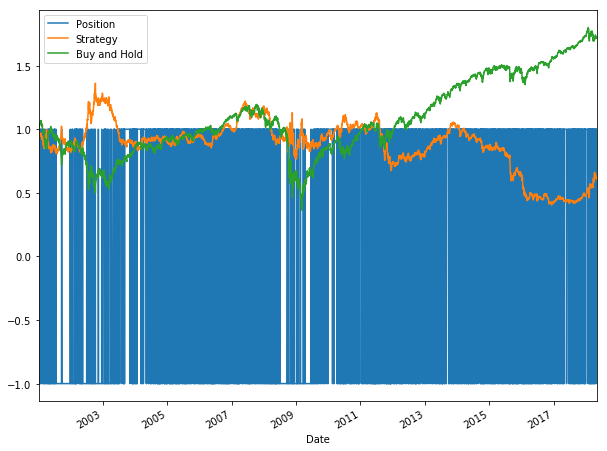

In [95]:
returns = pd.DataFrame(index   = signal.index, 
                       columns = ['Buy and Hold', 'Strategy'])
returns['Buy and Hold'] = lrets[-foreLength:]['Close']
returns['Position'    ] = signal['Close']
returns['Strategy'    ] = signal['Close'] * returns['Buy and Hold']

eqCurves = pd.DataFrame(index   = signal.index, 
                        columns = ['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold'] = returns['Buy and Hold'].cumsum() + 1
eqCurves['Position'    ] = returns['Position'    ]
eqCurves['Strategy'    ] = returns['Strategy'    ].cumsum() + 1 

eqCurves['Position'    ].plot(figsize=(10,8))
eqCurves['Strategy'    ].plot()
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()

If we look at the first decade of the backtest period, we see that the trading strategy did quite well in the early 2000s after the dot-com bubble burst as well as during the Great Recession in 2008-2009.

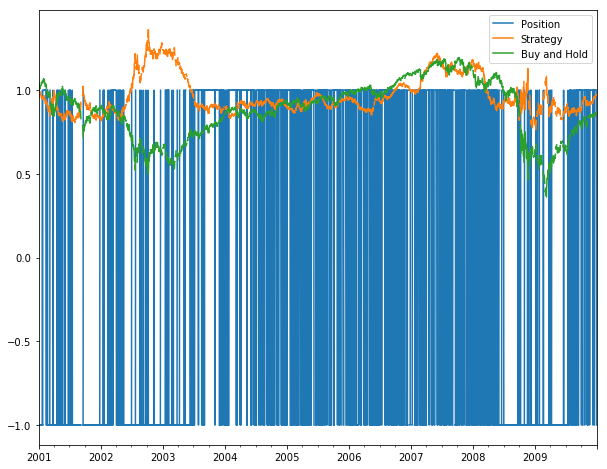

In [121]:
rng = pd.DatetimeIndex(start='20010101', freq='D', periods=9*365)
eqCurves.loc[rng]['Position'    ].plot(figsize=(10,8))
eqCurves.loc[rng]['Strategy'    ].plot()
eqCurves.loc[rng]['Buy and Hold'].plot()
plt.legend()
plt.show()

Again, looking at the recent bull market period, the trading strategy significantly underperforms the buy-and-hold strategy. 

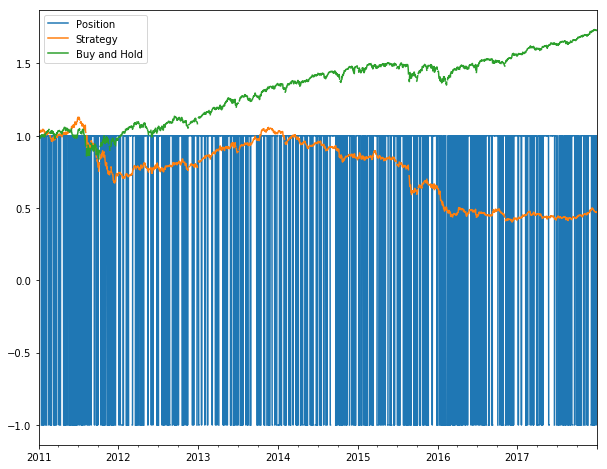

In [120]:
rng = pd.DatetimeIndex(start='20110101', freq='D', periods=7*365)
eqCurves.loc[rng]['Position'    ].plot(figsize=(10,8))
eqCurves.loc[rng]['Strategy'    ].plot()
eqCurves.loc[rng]['Buy and Hold'].plot()
plt.legend()
plt.show()

This was a very simple strategy and obviously not a very profitable one. Furthermore, this backtest does not account for slippage or trading costs, which would make this trading strategy completely untenable even if the above backtest was quite profitable. 

To productionalize trading strategies in reality, we could do a handful of things: 
- Test different instruments 
- Test different training windows  
- Apply thresholds to moderate the constant buying and selling (to reduce trading costs) 
- Combine this strategy with other strategies in a portfolio approach 

All that said, hopefully this demo illustrates some practical uses of GARCH modeling. 